In [7]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import timm  
import os
import random  
from tqdm.notebook import tqdm 
from torchvision import transforms as T, datasets, models
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.utils import make_grid
from torch import nn 
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns 
import csv

In [2]:
train_transforms = T.Compose([
    T.Resize((224, 224)),
    T.RandomRotation(degrees=20),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
full_dataset = datasets.ImageFolder(root='./Data')

In [4]:
from collections import Counter

class_counts = Counter(full_dataset.targets)
num_classes = len(full_dataset.classes)
total_samples = len(full_dataset)

weights = {class_idx: total_samples / (num_classes * count) for class_idx, count in class_counts.items()}

In [5]:
print(weights)

{0: 1.1510158013544018, 1: 0.8746140651801029, 2: 1.0556935817805384, 3: 1.6161648177496037, 4: 0.7033103448275863}


In [6]:
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
def augment_dataset(dataset, augmentation_transforms, augmentation_factor=0):
    augmented_data = []
    num_new_images = int(len(dataset) * augmentation_factor)
    for _ in range(num_new_images):
        index = random.randint(0, len(dataset) - 1)
        image, label = dataset.dataset[index]  # Access the underlying dataset
        augmented_image = augmentation_transforms(image)
        augmented_data.append((augmented_image, label))
    return augmented_data

In [9]:
original_train_dataset = CustomDataset(train_dataset, transform=train_transforms)
augmented_data = augment_dataset(original_train_dataset.dataset, train_transforms, augmentation_factor=0.05)
combined_train_dataset = ConcatDataset([original_train_dataset, augmented_data])

val_data = CustomDataset(val_dataset, transform=val_transforms)

In [10]:
del original_train_dataset, augmented_data

In [13]:
batch_size = 20

train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [14]:
# Function to show an image grid with an optional title.
def show_grid(image, title=None):
    image = image.permute(1, 2, 0)  # Rearranging the image tensor dimensions
    mean = torch.FloatTensor([0.485, 0.456, 0.406])  # Mean for denormalization
    std = torch.FloatTensor([0.229, 0.224, 0.225])  # Standard deviation for denormalization

    image = image * std + mean  # Apply denormalization
    image = np.clip(image, 0, 1)  # Clip values to be between 0 and 1

    plt.figure(figsize=[15, 15])  # Set the size of the figure
    plt.imshow(image)  # Display the image grid
    if title is not None:
        plt.title(title)  # Set the title if provided

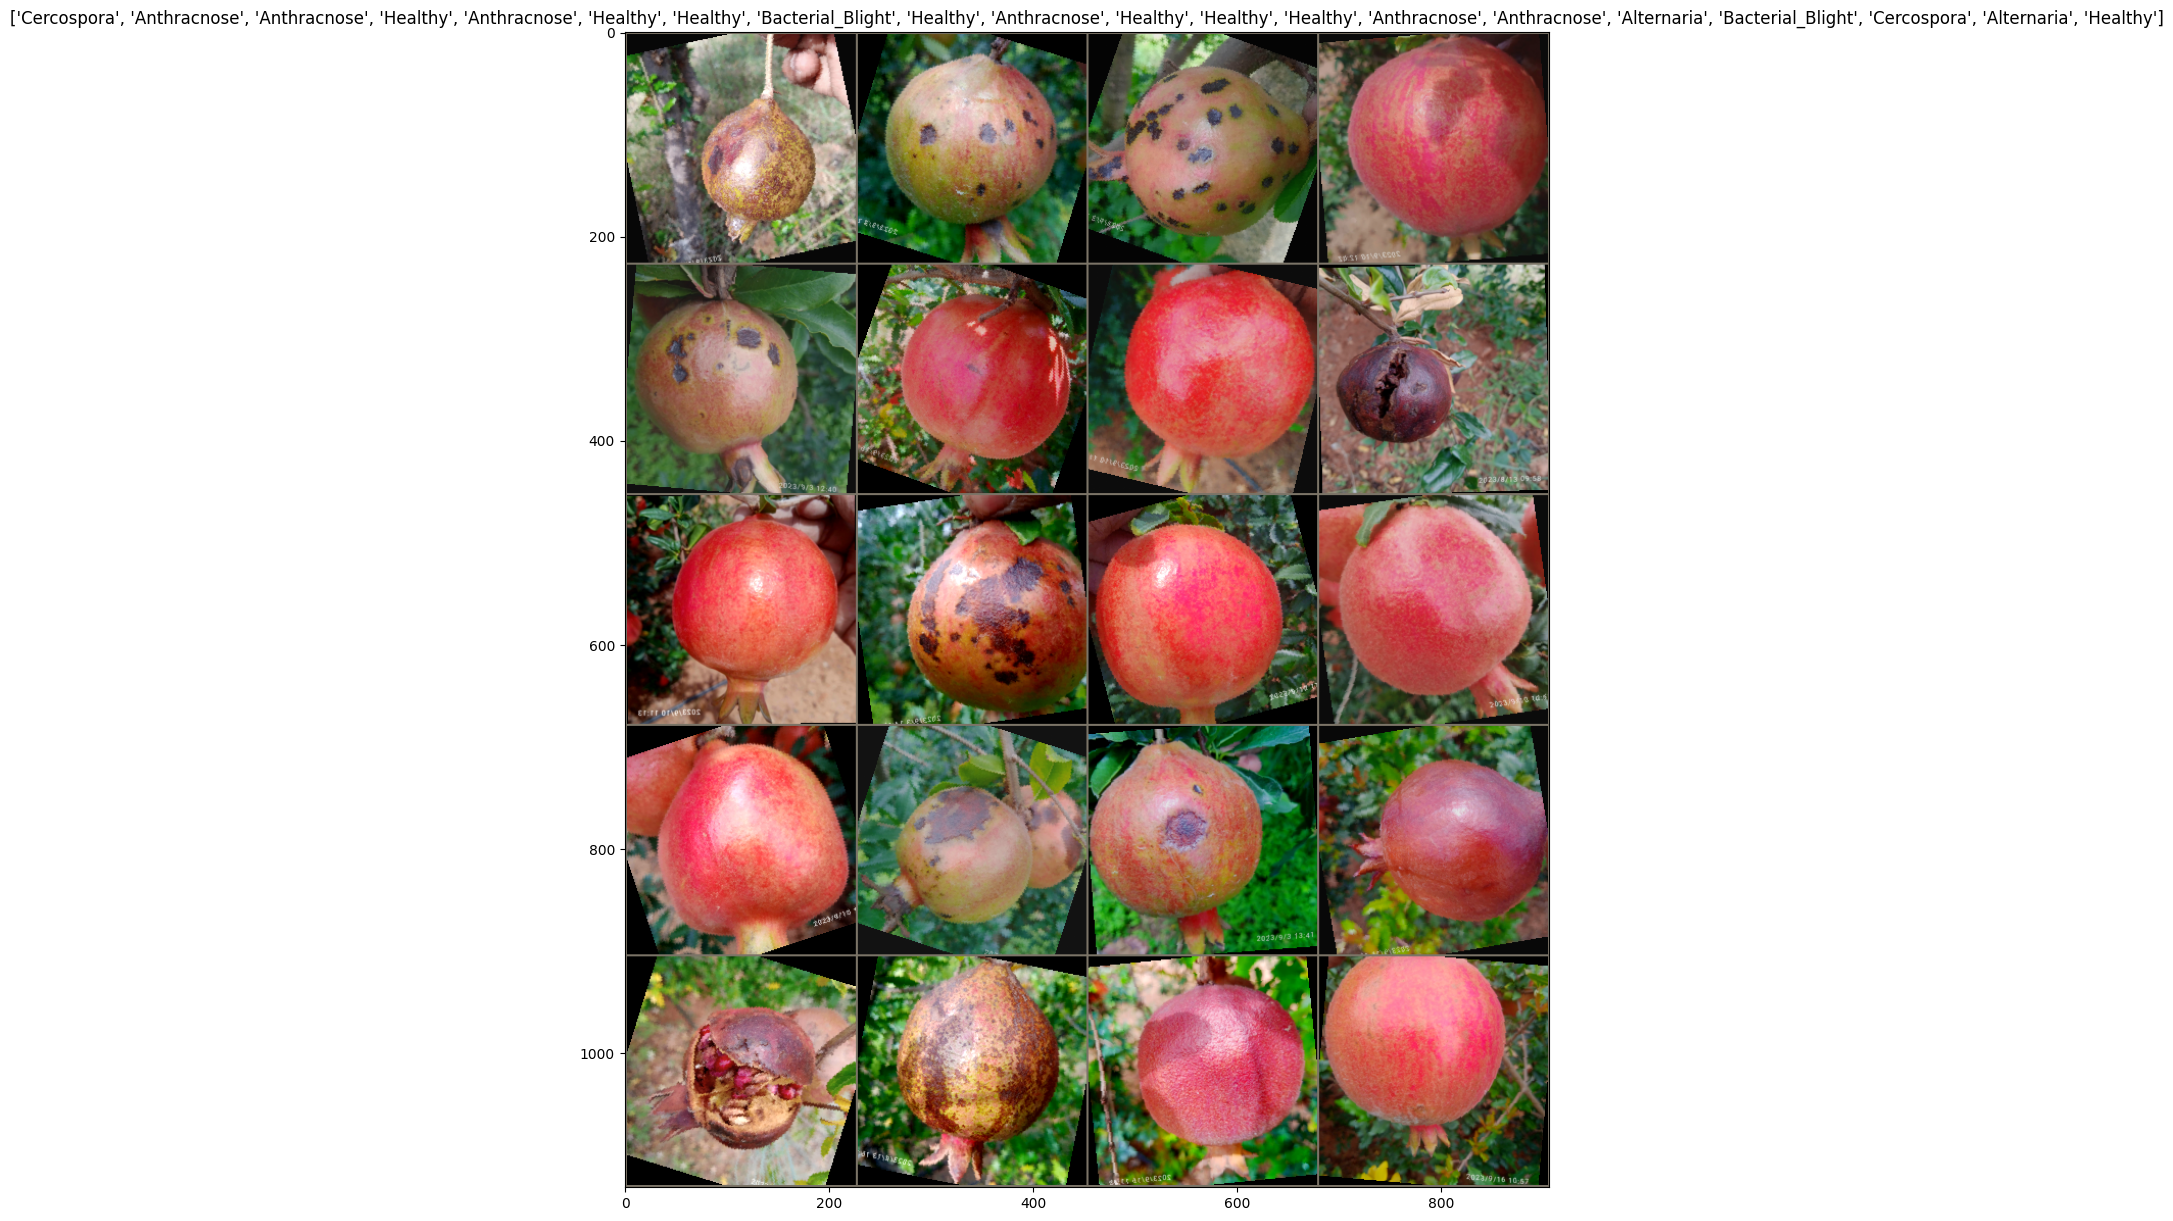

In [15]:
# Defining the class names for the dataset
class_names = ['Alternaria','Anthracnose', 'Bacterial_Blight', 'Cercospora', 'Healthy']  # List of class names, corresponding to the labels in the dataset

# Iterating through the trainloader to fetch a batch of images
dataiter = iter(train_loader)  # Create an iterator for the trainloader
images, labels = dataiter.__next__()  # Fetch the next batch of images and their corresponding labels

# Creating a grid layout of the fetched images
out = make_grid(images, nrow=4)  # Using make_grid to arrange images in a grid format, 4 images per row

# Displaying the grid of images
show_grid(out, title=[class_names[x] for x in labels])  # Using the custom show_grid function to display the images with their class names as titles

In [8]:
model = models.efficientnet_v2_m(pretrained=True)
# Setting the device for training/testing. Uses GPU if available, else CPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Print statement to confirm the device being used
print("On which device we are on : {}".format(device))

On which device we are on : cuda:1


In [9]:
num_classes = 5  # 'Alternaria', 'Anthracnose', 'Bacterial Blight', 'Cercospora', 'Healthy'
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True) 
)
model.to(device)  # Transferring the model to the device (GPU or CPU) for efficient computation

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [13]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total parameters: 52864761
Total trainable parameters: 52864761


In [19]:
# Function to calculate the accuracy of predictions.
def accuracy(y_pred, y_true):
    y_pred = F.softmax(y_pred, dim=1)  # Apply softmax to get probability distributions
    top_p, top_class = y_pred.topk(1, dim=1)  # Get the top class predictions
    equals = top_class == y_true.view(*top_class.shape)  # Compare with true labels
    return torch.mean(equals.type(torch.FloatTensor))  # Calculate the mean accuracy

In [20]:
# Trainer class for handling the training and validation of a neural network model for pneumonia detection
class Trainer():

    # Constructor for initializing the trainer with a loss function, optimizer, and scheduler
    def __init__(self, criterion=None, optimizer=None, schedular=None):
        self.criterion = criterion  # Loss function to use
        self.optimizer = optimizer  # Optimizer for adjusting model weights
        self.schedular = schedular  # Learning rate scheduler 
        # Initialize lists to store metrics for plotting
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
    
    # Function to perform the training loop over all batches in the training data
    def train_batch_loop(self, model, trainloader, device):
        train_loss = 0.0  # Variable to accumulate loss over all batches
        train_acc = 0.0   # Variable to accumulate accuracy over all batches

        # Iterate over batches of images and labels in the training dataset
        for images, labels in tqdm(trainloader):
            
            # Move images and labels to the device (GPU or CPU)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass: compute predicted outputs by passing images to the model
            logits = model(images)
            loss = self.criterion(logits, labels)  # Calculate the batch's loss

            # Backward pass and optimization
            self.optimizer.zero_grad()  # Clear the gradients of all optimized variables
            loss.backward()  # Perform backward pass to calculate gradients
            self.optimizer.step()  # Perform a single optimization step (parameter update)

            # Accumulate loss and accuracy for this batch
            train_loss += loss.item()
            train_acc += accuracy(logits, labels)

        # Calculate average loss and accuracy over all batches
        return train_loss / len(trainloader), train_acc / len(trainloader)
    
    # Function to perform the validation loop over all batches in the validation data
    def valid_batch_loop(self, model, validloader, device):
        valid_loss = 0.0
        valid_acc = 0.0
        all_preds = []
        all_labels = []
        all_logits = []

        for images, labels in tqdm(validloader):
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = self.criterion(logits, labels)

            valid_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())
            all_logits.extend(logits.detach().cpu().numpy())

        # Calculate average loss and accuracy
        avg_loss = valid_loss / len(validloader)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_preds)

        # Calculate metrics
        all_preds = np.argmax(all_logits, axis=1)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)

        return avg_loss, accuracy, precision, recall, f1, conf_matrix
    
    def save_metrics_to_csv(self, filepath, epoch):
        with open(filepath, mode='a', newline='') as file:
            writer = csv.writer(file)
            if epoch == 1:  # Write the header only once, at the beginning
                writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy'])
            writer.writerow([epoch, self.train_losses[-1], self.train_accuracies[-1], self.val_losses[-1], self.val_accuracies[-1]])

    def plot_metrics(self, epoch):
        # Plotting training and validation loss
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.title(f'Loss after Epoch {epoch}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting training and validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='Training Accuracy')
        plt.plot(self.val_accuracies, label='Validation Accuracy')
        plt.title(f'Accuracy after Epoch {epoch}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

    def fit(self, model, trainloader, validloader, epochs, device):
        metrics_filepath = f'EfficientNet_M_training_metrics.csv'
        valid_min_loss = np.Inf

        for i in range(epochs):
            model.train()
            avg_train_loss, avg_train_acc = self.train_batch_loop(model, trainloader, device)

            model.eval()
            avg_valid_loss, avg_valid_acc, precision, recall, f1, conf_matrix = self.valid_batch_loop(model, validloader, device)

            if self.schedular:
                self.schedular.step(avg_valid_loss)
            
            # Save the model after every epoch
            epoch_number = i + 1
            model_filename = f'EfficientNet_M_Epoch_{epoch_number}.pth'
            torch.save(model.state_dict(), model_filename)
            print(f"Model saved as {model_filename}")

            # Track the best model based on validation loss
            if avg_valid_loss <= valid_min_loss:
                print("Valid_loss decreased {} --> {}".format(valid_min_loss, avg_valid_loss))
                valid_min_loss = avg_valid_loss

            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(epoch_number, avg_train_loss, avg_train_acc))
            print(f"Epoch {epoch_number}/{epochs} - Valid Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

            # Update lists for plotting
            self.train_losses.append(avg_train_loss)
            self.train_accuracies.append(avg_train_acc)
            self.val_losses.append(avg_valid_loss)
            self.val_accuracies.append(avg_valid_acc)

            # Save metrics to CSV after each epoch
            self.save_metrics_to_csv(metrics_filepath, i + 1)

            # Plot metrics
            self.plot_metrics(epoch_number)

            # Plot the confusion matrix
            plt.figure(figsize=(10, 8))
            sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
                        xticklabels=class_names, yticklabels=class_names)
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title(f'Confusion Matrix at Epoch {i + 1}')
            plt.show()

In [21]:
print(torch.cuda.memory_allocated()/1024**2)
print(torch.cuda.memory_reserved()/1024**2)

0.0
0.0


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_1.pth
Valid_loss decreased inf --> 0.31188380546480804
Epoch : 1 Train Loss : 0.388662 Train Acc : 0.880091
Epoch 1/50 - Valid Loss: 0.3119, Accuracy: 0.8974, Precision: 0.9209, Recall: 0.8974, F1 Score: 0.8985


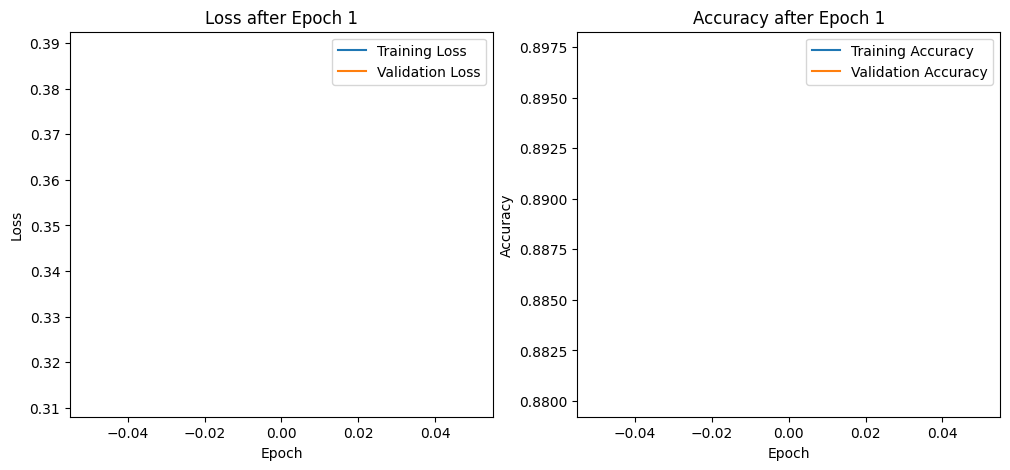

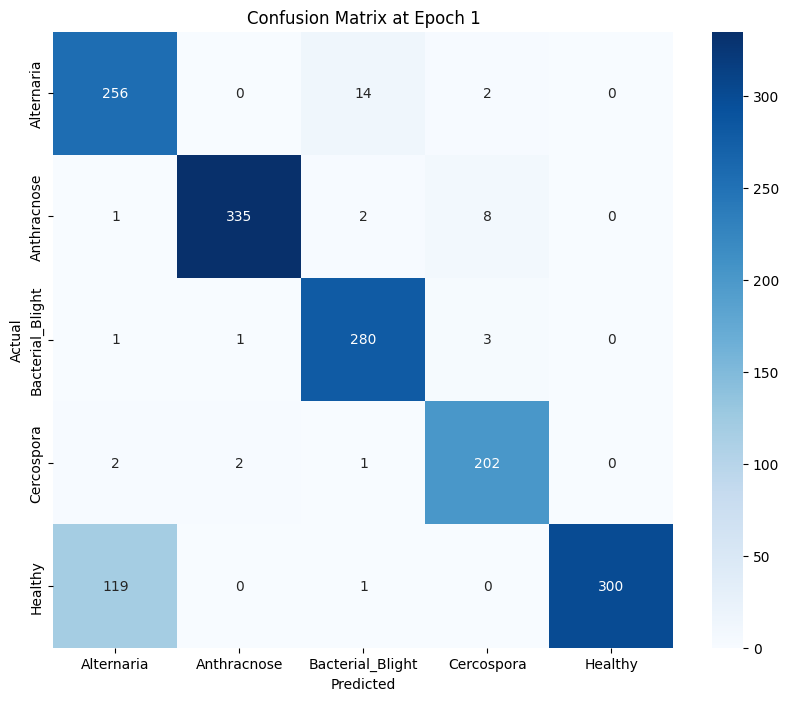

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_2.pth
Valid_loss decreased 0.31188380546480804 --> 0.292107853917526
Epoch : 2 Train Loss : 0.210311 Train Acc : 0.938373
Epoch 2/50 - Valid Loss: 0.2921, Accuracy: 0.9092, Precision: 0.9301, Recall: 0.9092, F1 Score: 0.9098


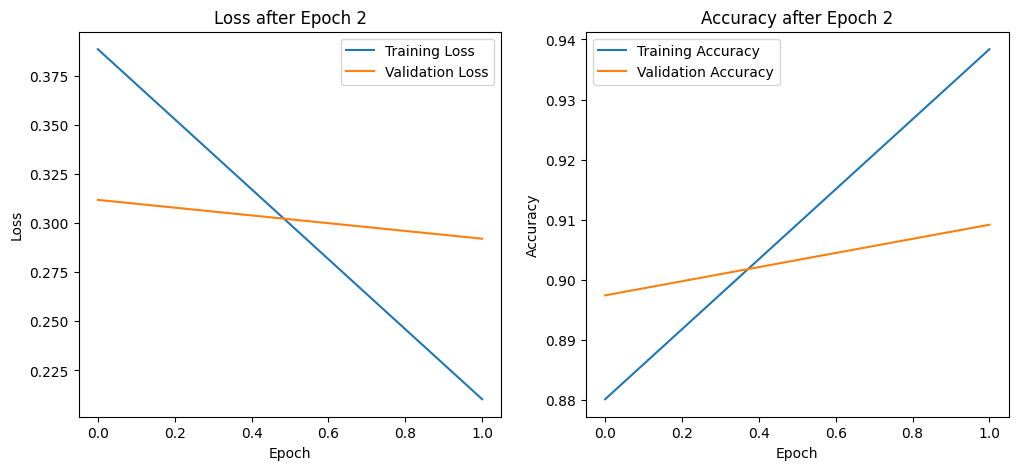

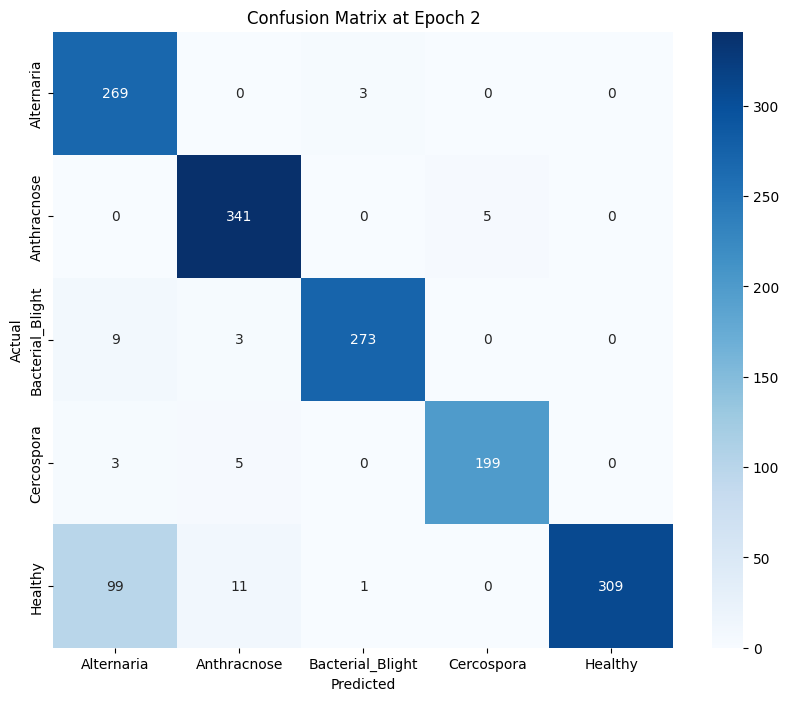

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_3.pth
Valid_loss decreased 0.292107853917526 --> 0.10401300804133153
Epoch : 3 Train Loss : 0.156498 Train Acc : 0.955318
Epoch 3/50 - Valid Loss: 0.1040, Accuracy: 0.9667, Precision: 0.9684, Recall: 0.9667, F1 Score: 0.9667


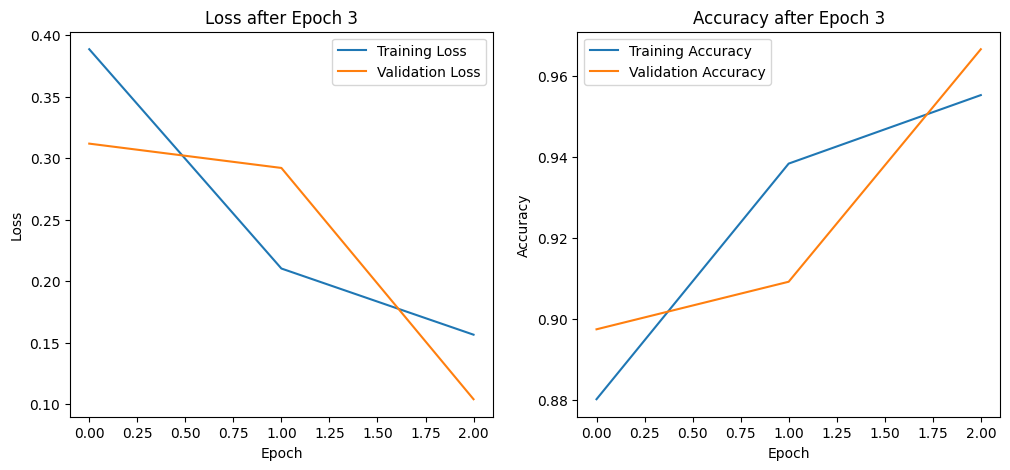

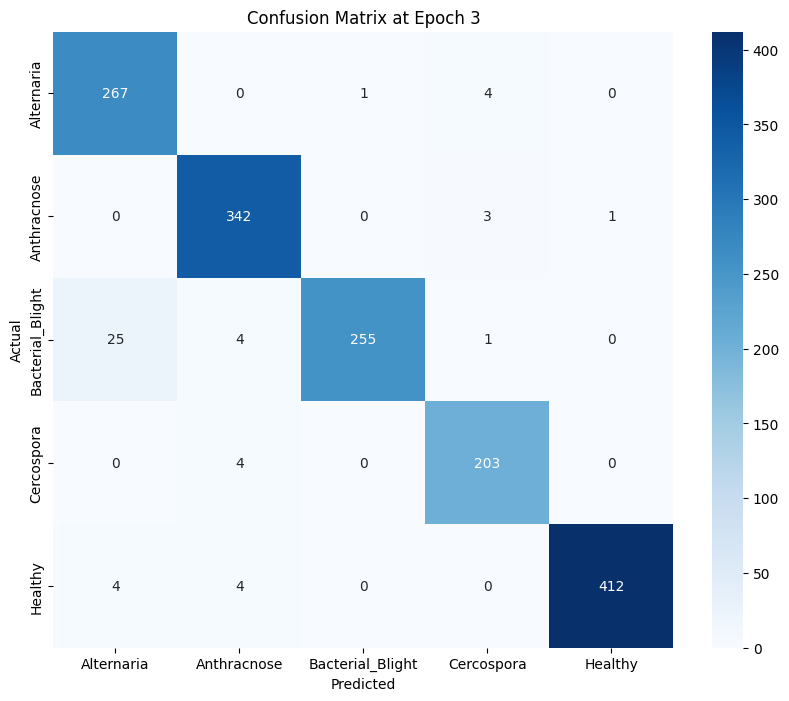

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_4.pth
Valid_loss decreased 0.10401300804133153 --> 0.05960680679992664
Epoch : 4 Train Loss : 0.120822 Train Acc : 0.961701
Epoch 4/50 - Valid Loss: 0.0596, Accuracy: 0.9771, Precision: 0.9774, Recall: 0.9771, F1 Score: 0.9771


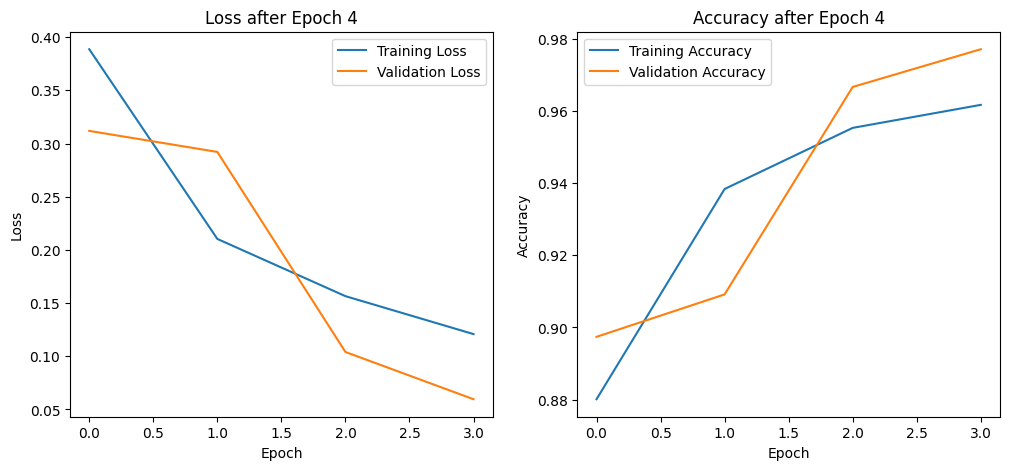

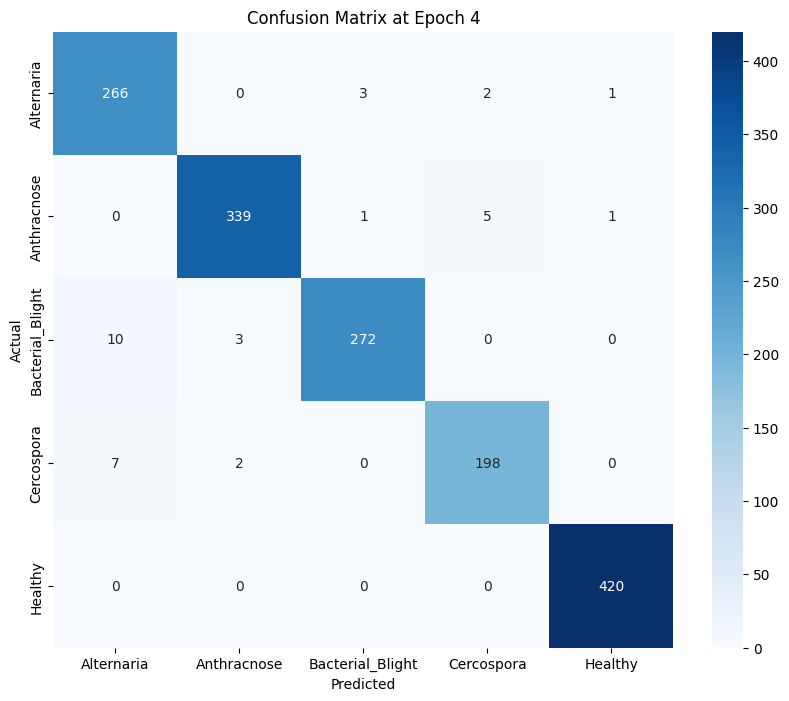

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_5.pth
Epoch : 5 Train Loss : 0.100577 Train Acc : 0.970744
Epoch 5/50 - Valid Loss: 0.0618, Accuracy: 0.9882, Precision: 0.9883, Recall: 0.9882, F1 Score: 0.9883


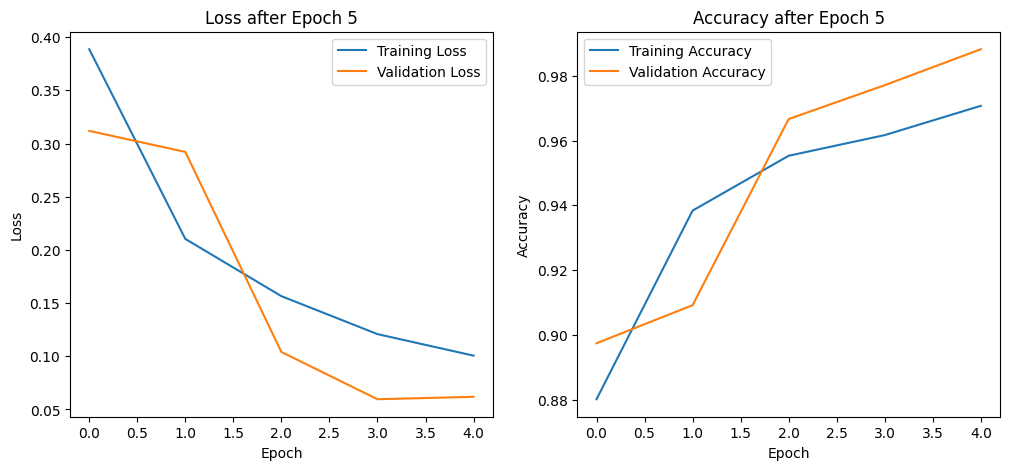

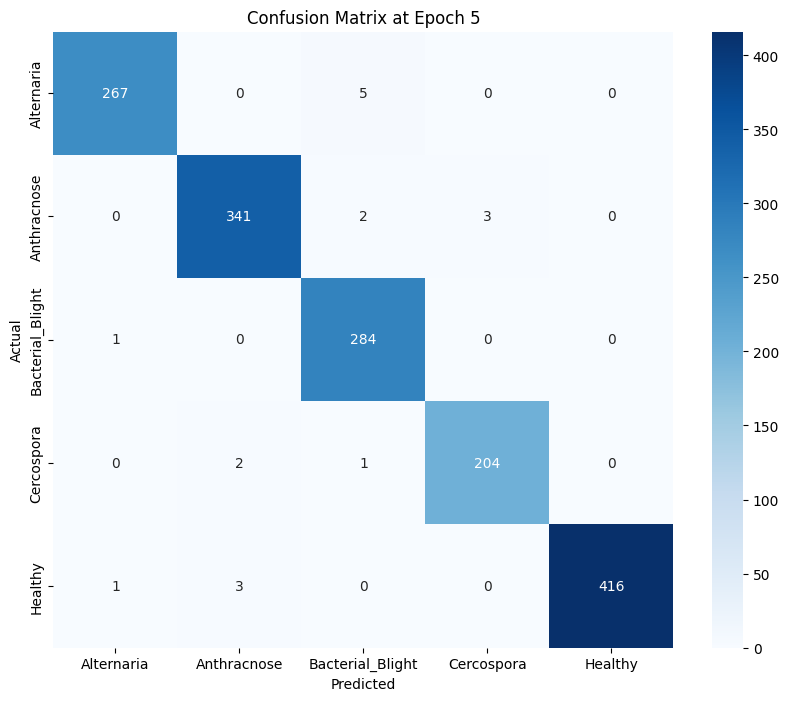

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_6.pth
Epoch : 6 Train Loss : 0.072775 Train Acc : 0.976405
Epoch 6/50 - Valid Loss: 0.0813, Accuracy: 0.9771, Precision: 0.9771, Recall: 0.9771, F1 Score: 0.9771


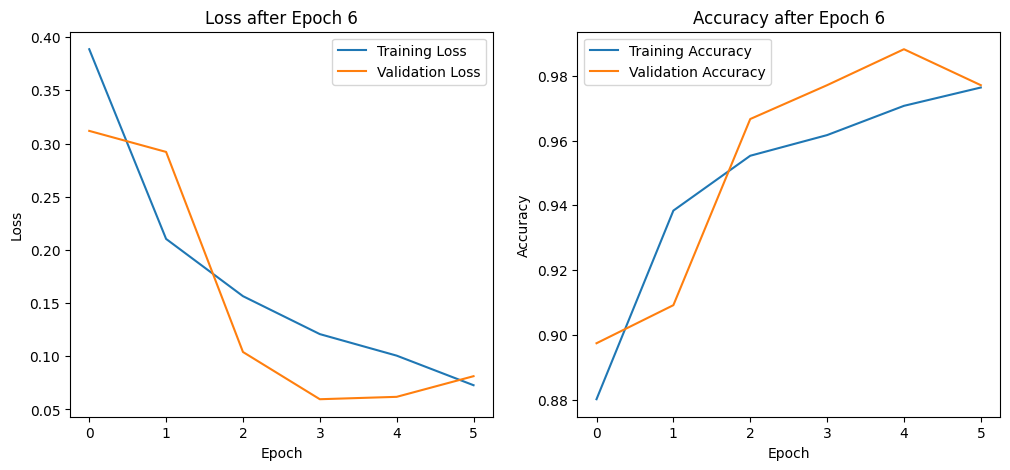

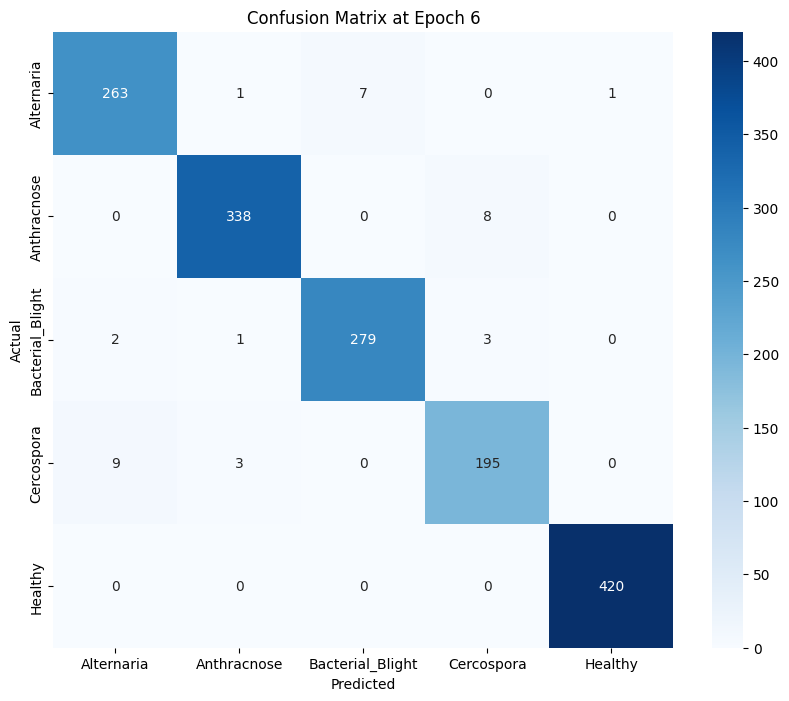

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_7.pth
Epoch : 7 Train Loss : 0.095513 Train Acc : 0.970478
Epoch 7/50 - Valid Loss: 0.0667, Accuracy: 0.9830, Precision: 0.9833, Recall: 0.9830, F1 Score: 0.9831


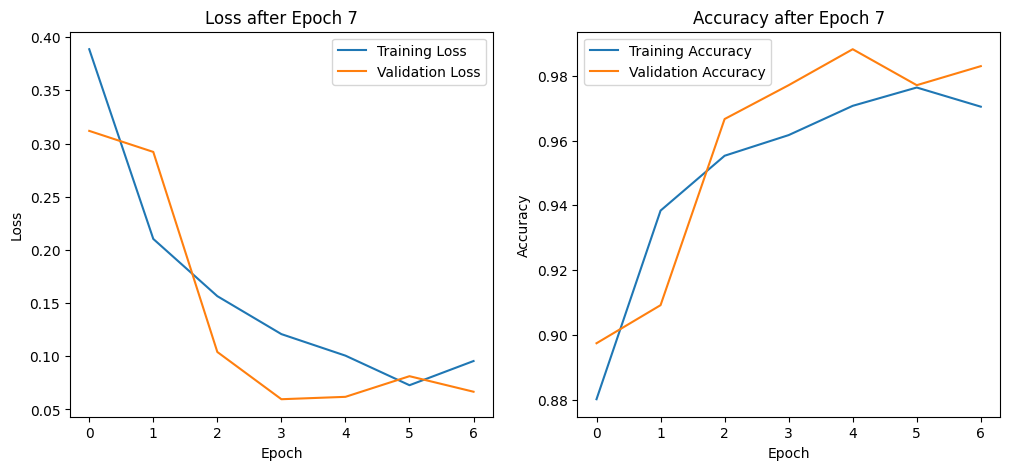

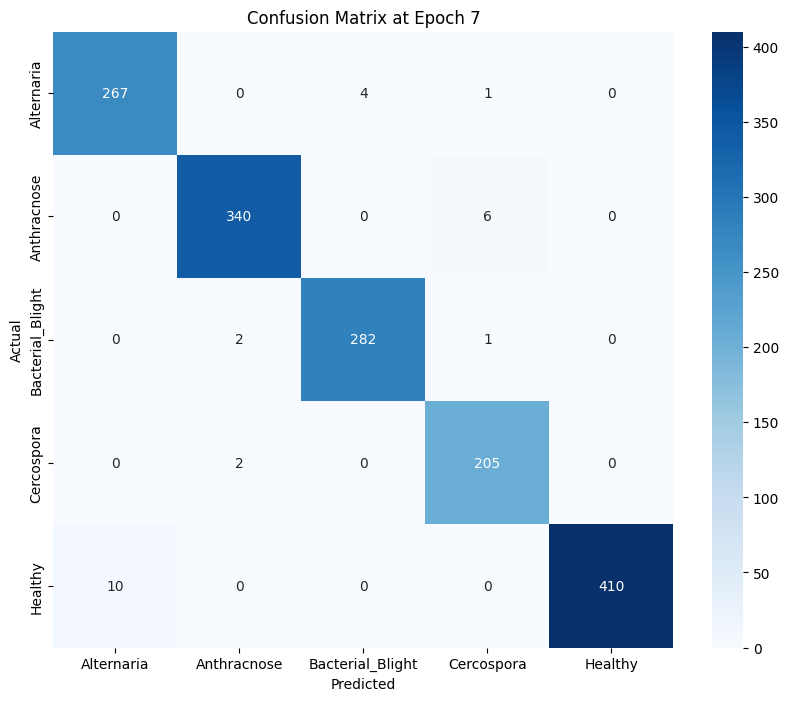

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_8.pth
Epoch : 8 Train Loss : 0.108509 Train Acc : 0.966223
Epoch 8/50 - Valid Loss: 0.1008, Accuracy: 0.9758, Precision: 0.9772, Recall: 0.9758, F1 Score: 0.9756


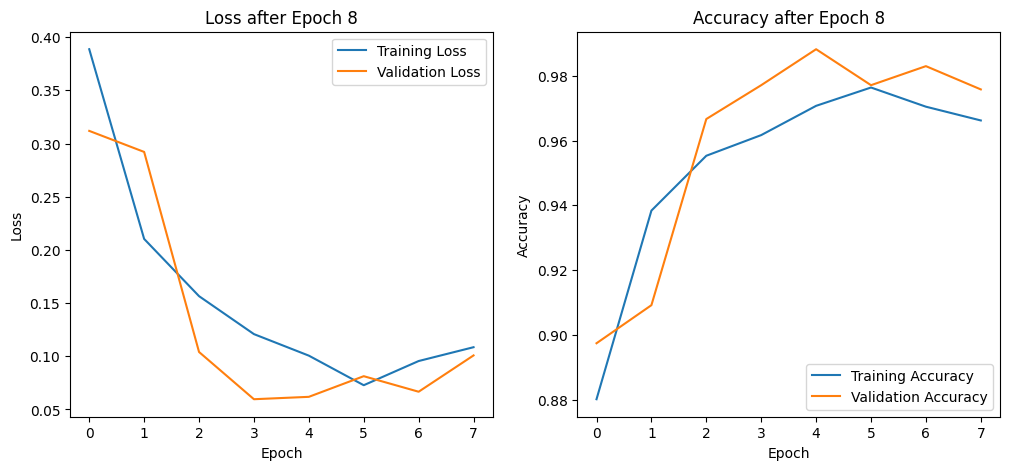

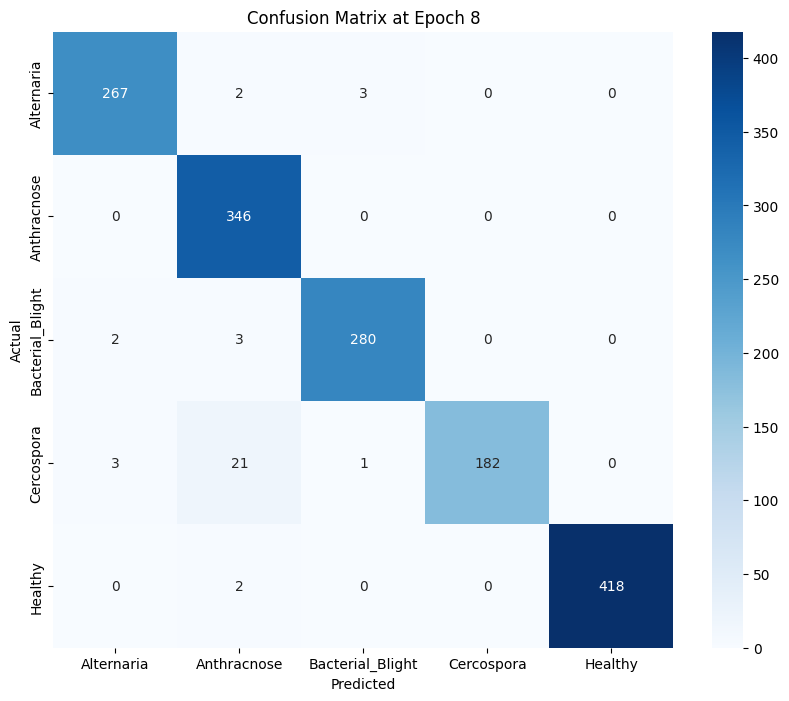

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_9.pth
Valid_loss decreased 0.05960680679992664 --> 0.0465607072027134
Epoch : 9 Train Loss : 0.073982 Train Acc : 0.980319
Epoch 9/50 - Valid Loss: 0.0466, Accuracy: 0.9902, Precision: 0.9902, Recall: 0.9902, F1 Score: 0.9902


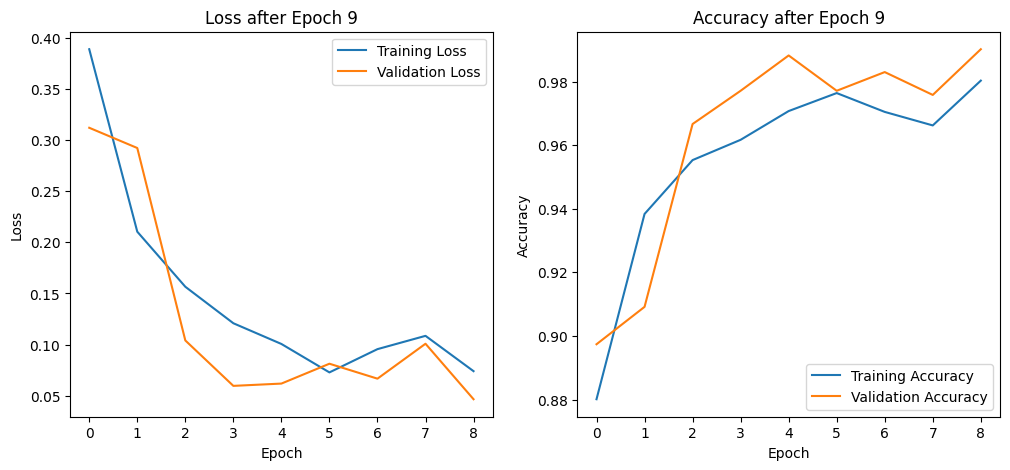

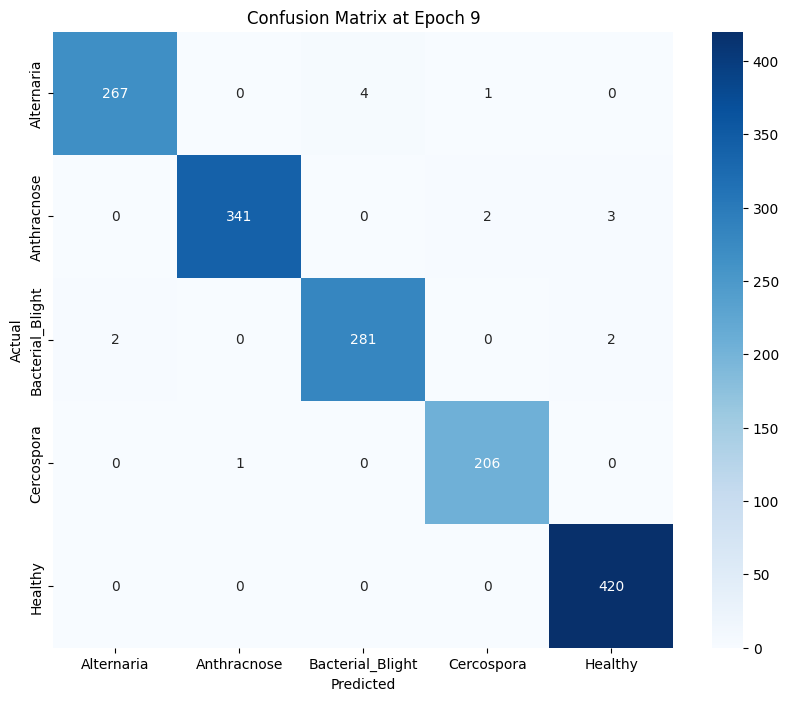

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_10.pth
Epoch : 10 Train Loss : 0.105811 Train Acc : 0.968617
Epoch 10/50 - Valid Loss: 0.0816, Accuracy: 0.9810, Precision: 0.9812, Recall: 0.9810, F1 Score: 0.9809


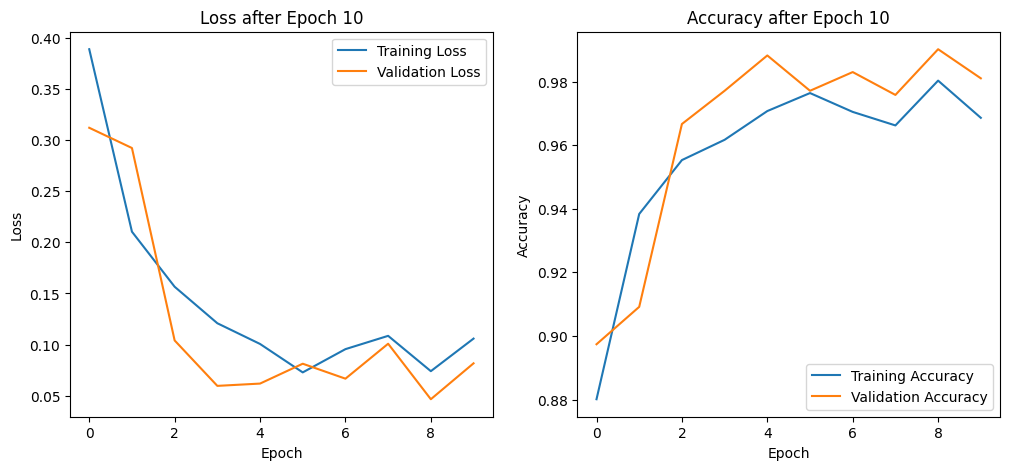

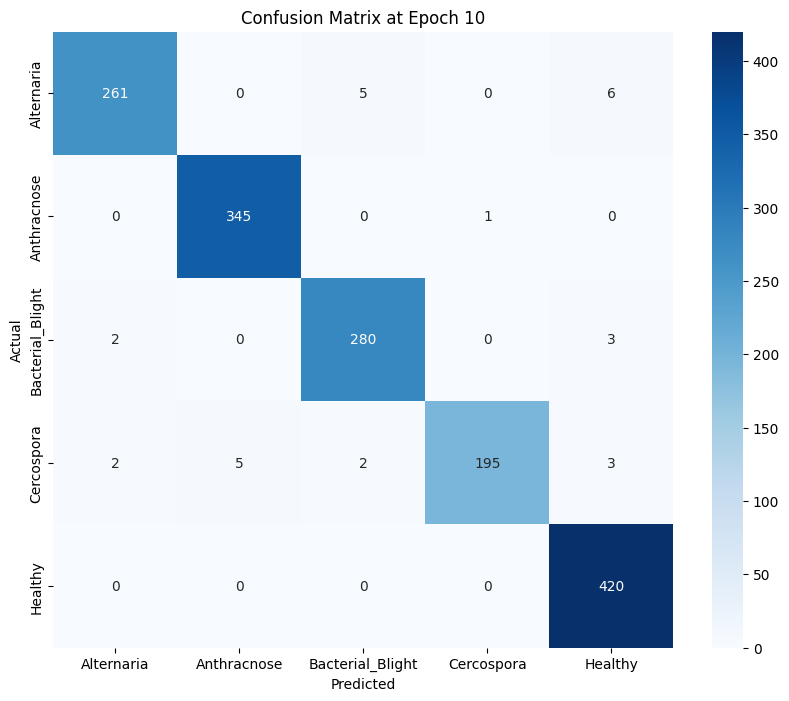

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_11.pth
Epoch : 11 Train Loss : 0.072076 Train Acc : 0.976595
Epoch 11/50 - Valid Loss: 0.0860, Accuracy: 0.9810, Precision: 0.9824, Recall: 0.9810, F1 Score: 0.9812


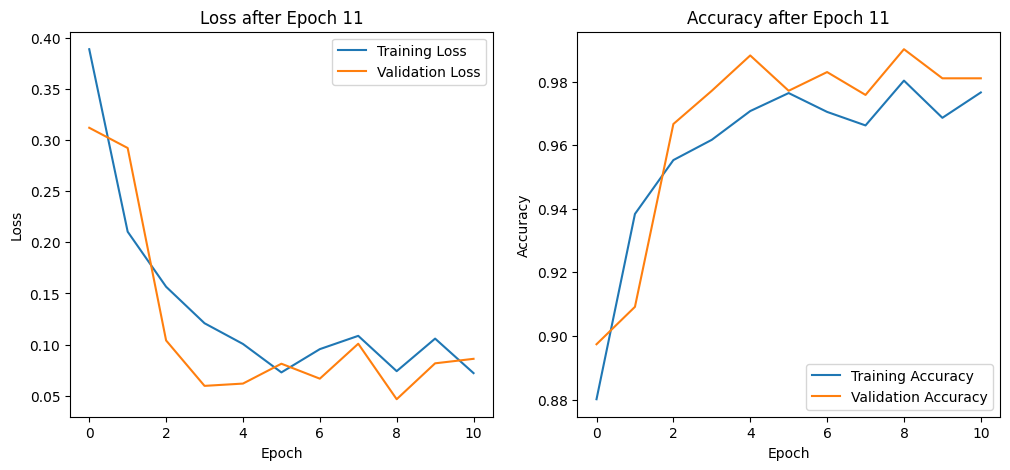

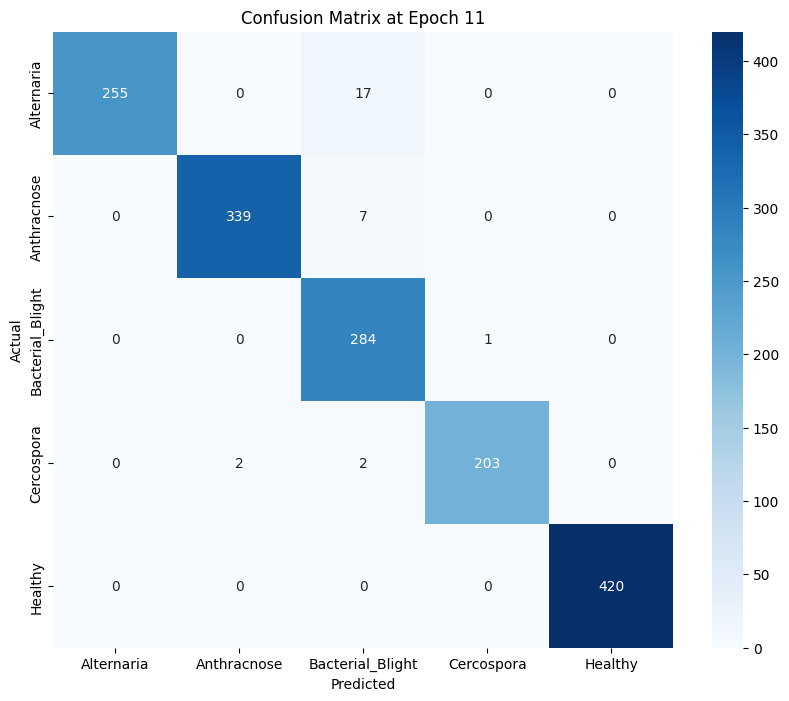

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_12.pth
Epoch : 12 Train Loss : 0.042279 Train Acc : 0.985904
Epoch 12/50 - Valid Loss: 0.0549, Accuracy: 0.9843, Precision: 0.9844, Recall: 0.9843, F1 Score: 0.9843


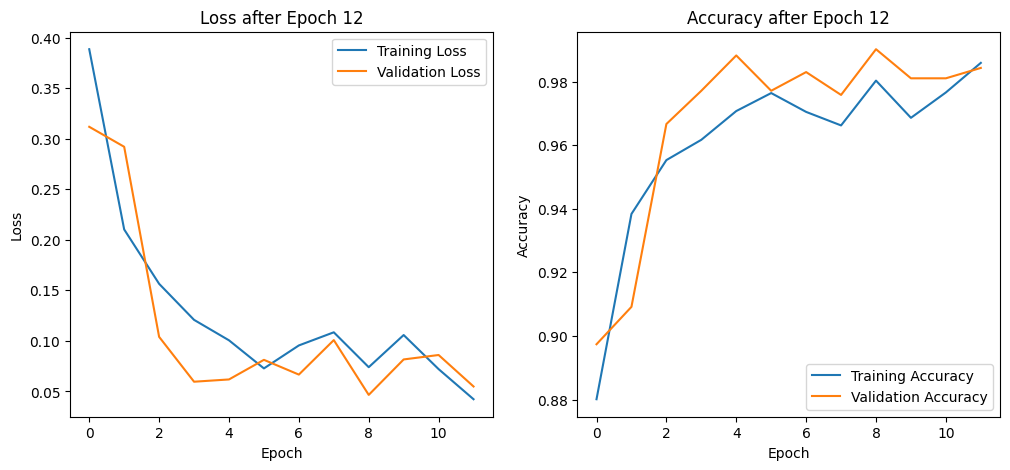

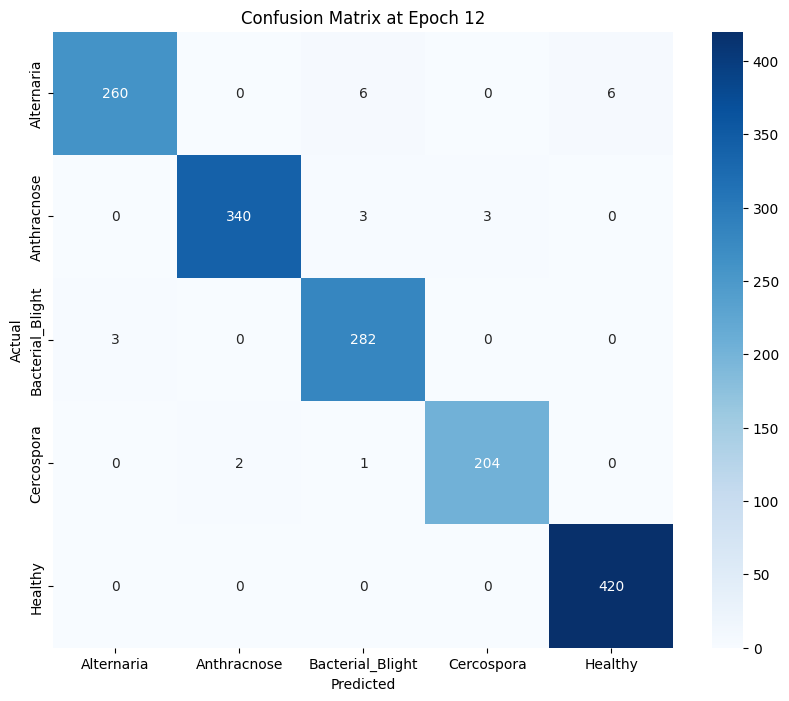

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_13.pth
Epoch : 13 Train Loss : 0.075918 Train Acc : 0.977925
Epoch 13/50 - Valid Loss: 0.0576, Accuracy: 0.9837, Precision: 0.9837, Recall: 0.9837, F1 Score: 0.9836


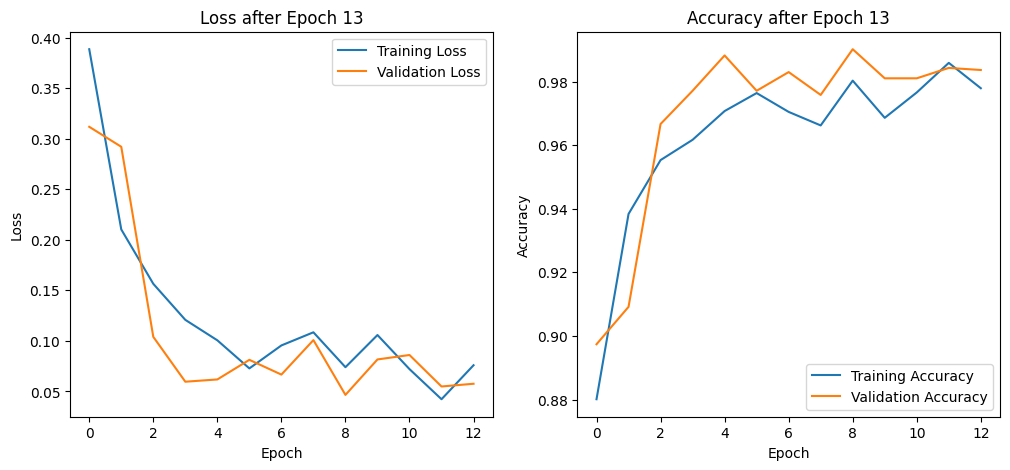

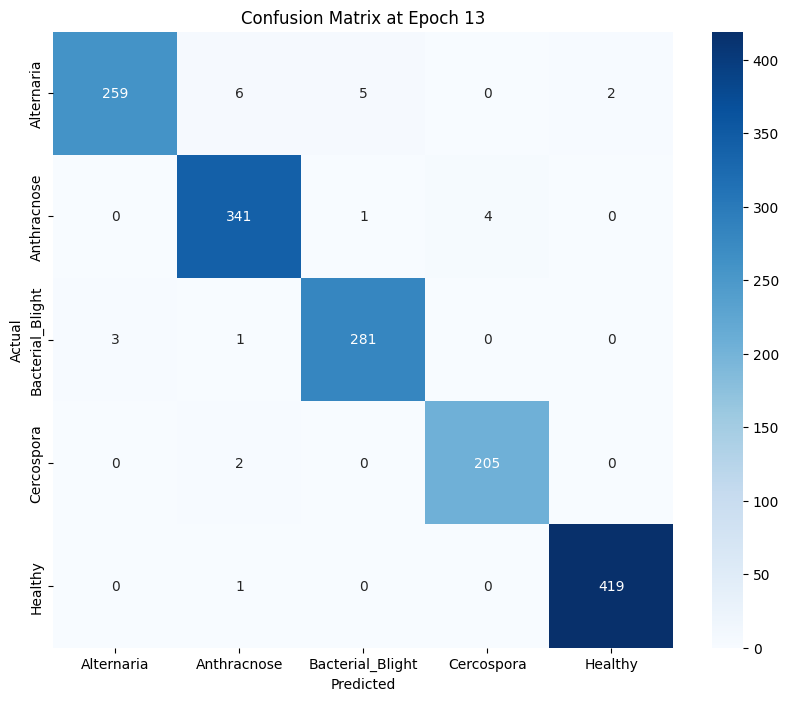

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_14.pth
Epoch : 14 Train Loss : 0.067231 Train Acc : 0.980319
Epoch 14/50 - Valid Loss: 0.0689, Accuracy: 0.9797, Precision: 0.9801, Recall: 0.9797, F1 Score: 0.9798


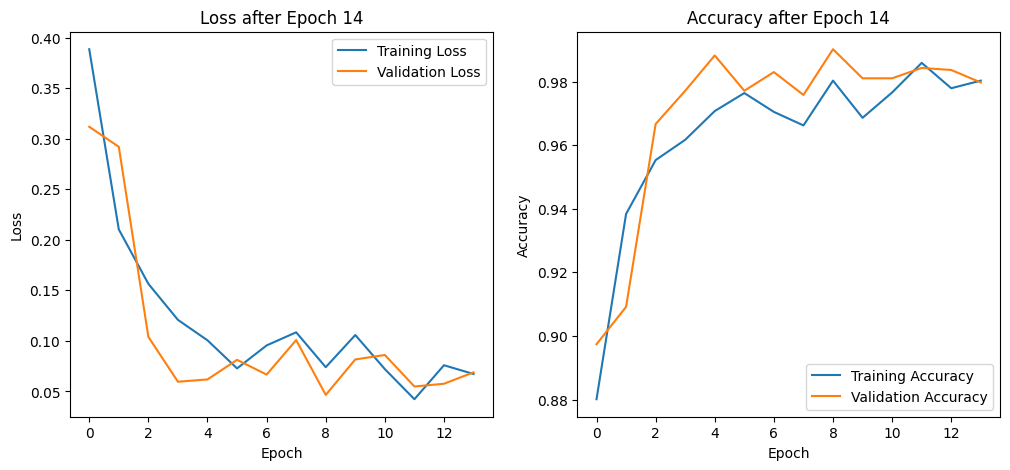

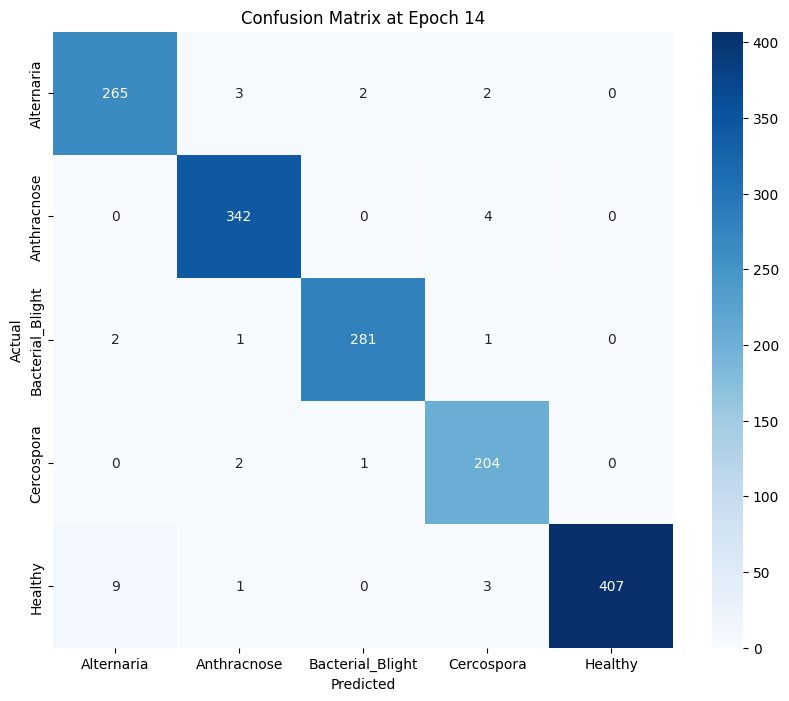

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_15.pth
Epoch : 15 Train Loss : 0.064390 Train Acc : 0.982978
Epoch 15/50 - Valid Loss: 0.0628, Accuracy: 0.9824, Precision: 0.9826, Recall: 0.9824, F1 Score: 0.9823


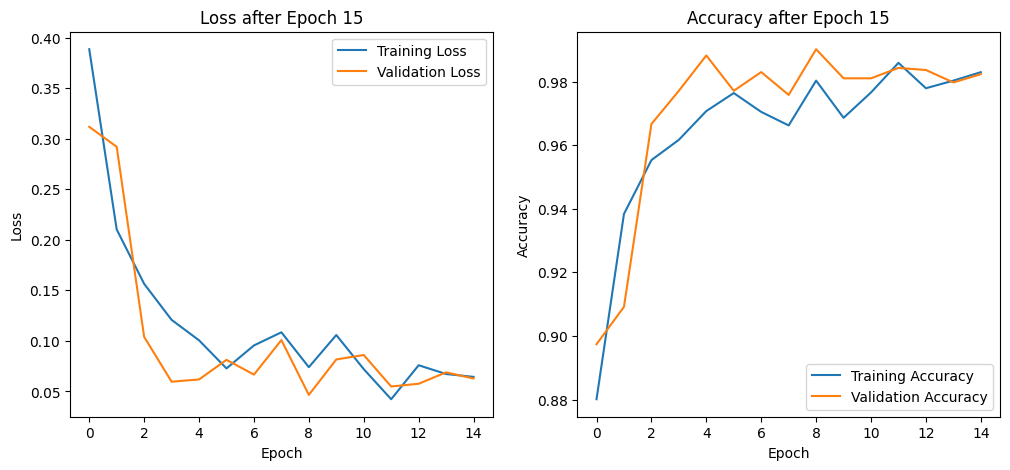

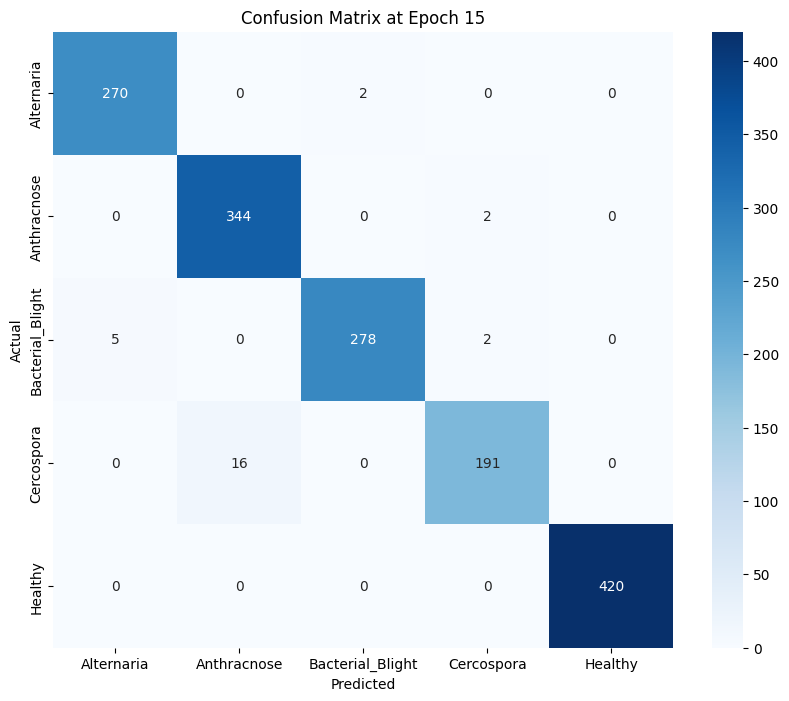

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_16.pth
Epoch : 16 Train Loss : 0.046191 Train Acc : 0.983776
Epoch 16/50 - Valid Loss: 0.0998, Accuracy: 0.9712, Precision: 0.9722, Recall: 0.9712, F1 Score: 0.9711


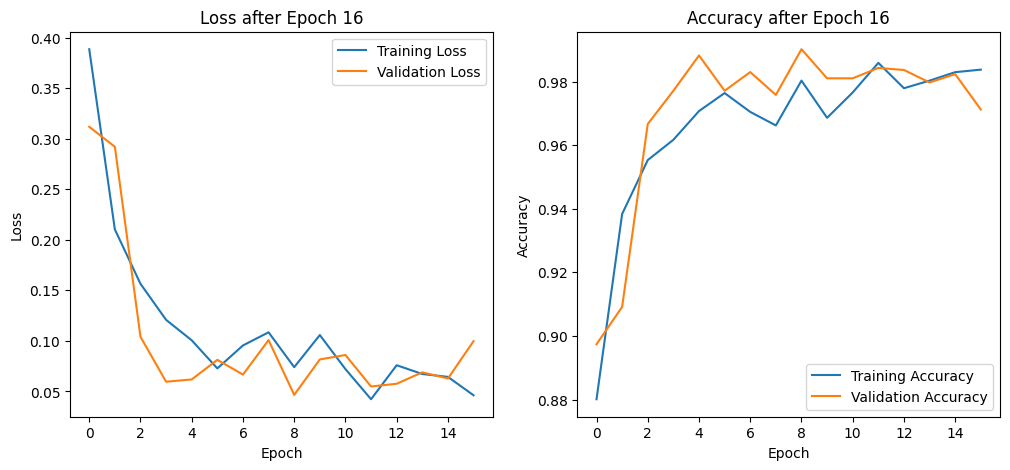

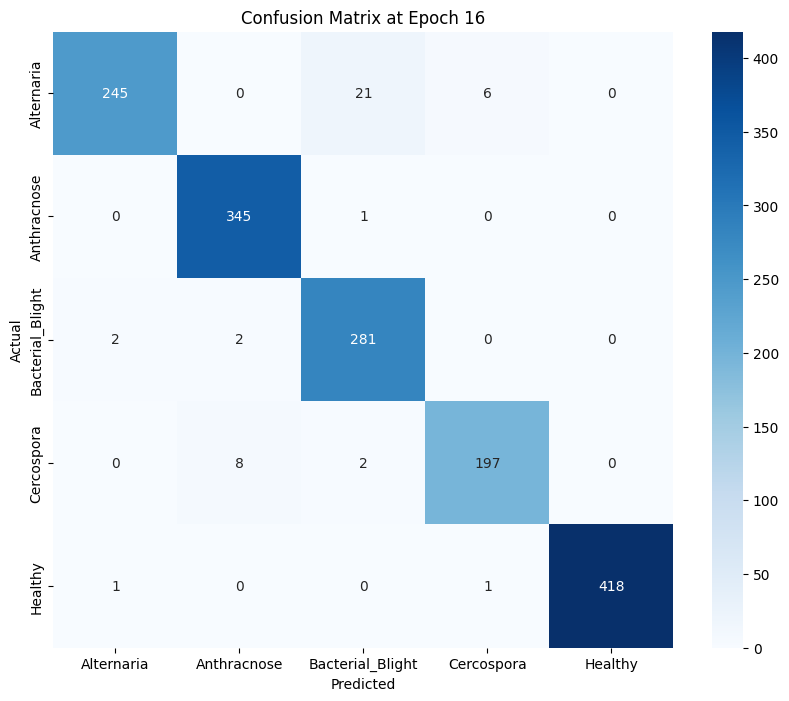

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_17.pth
Epoch : 17 Train Loss : 0.054179 Train Acc : 0.984574
Epoch 17/50 - Valid Loss: 0.0495, Accuracy: 0.9830, Precision: 0.9833, Recall: 0.9830, F1 Score: 0.9831


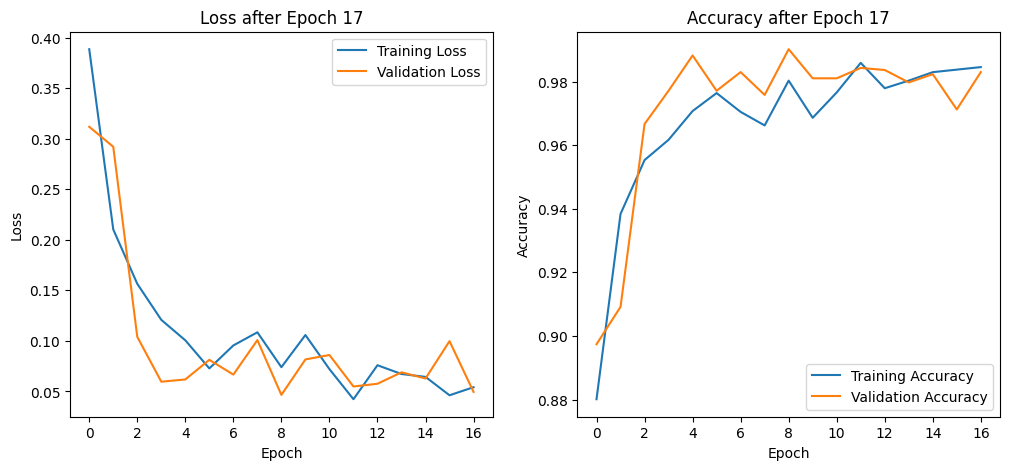

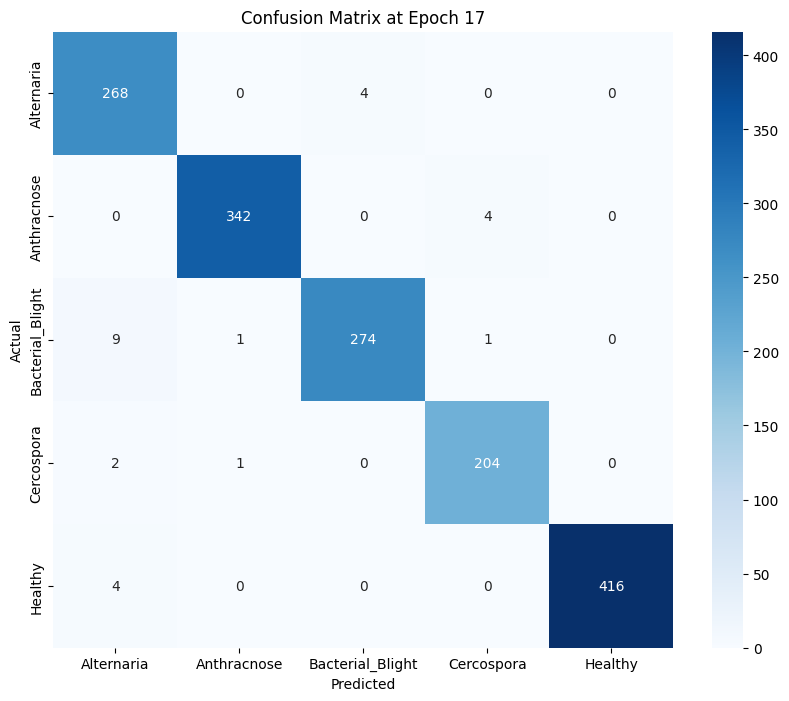

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_18.pth
Epoch : 18 Train Loss : 0.058231 Train Acc : 0.979787
Epoch 18/50 - Valid Loss: 0.0909, Accuracy: 0.9752, Precision: 0.9757, Recall: 0.9752, F1 Score: 0.9752


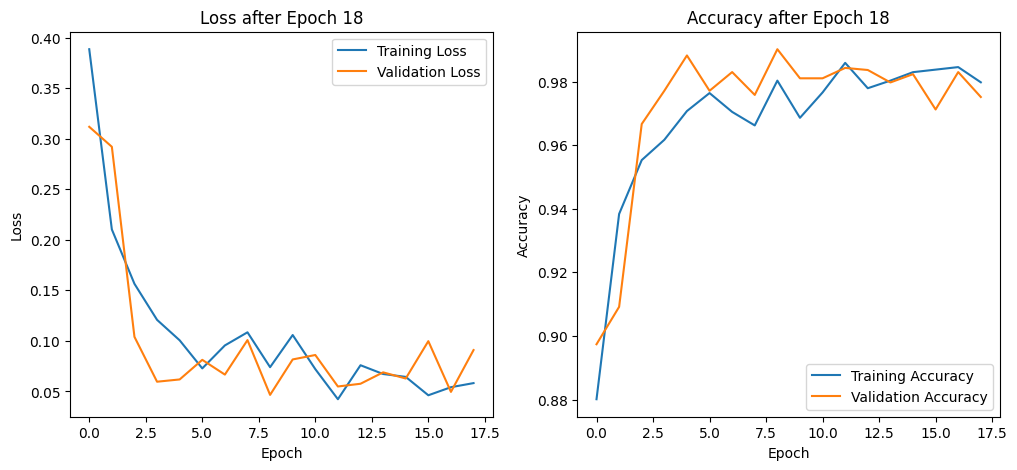

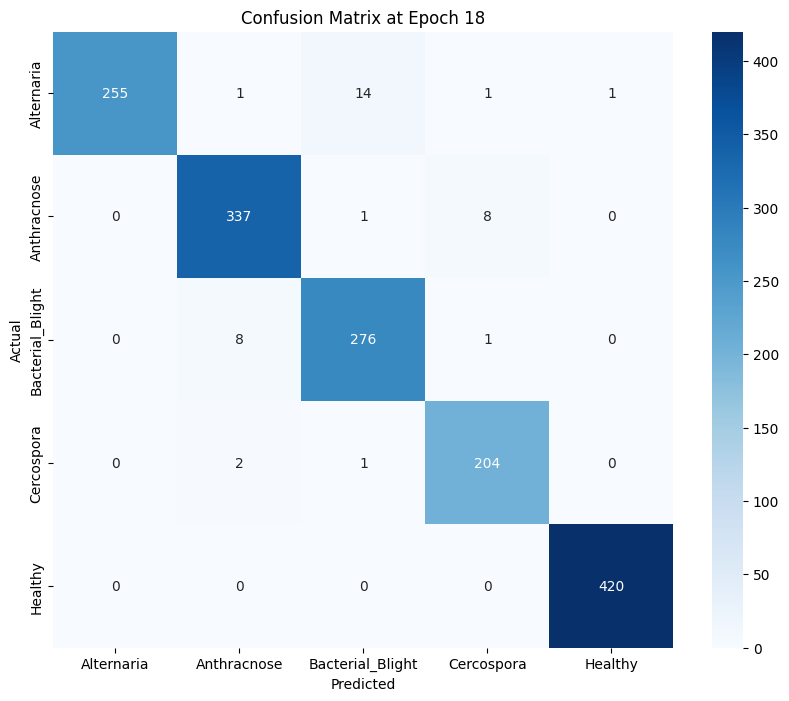

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_19.pth
Epoch : 19 Train Loss : 0.040557 Train Acc : 0.988564
Epoch 19/50 - Valid Loss: 0.0746, Accuracy: 0.9810, Precision: 0.9815, Recall: 0.9810, F1 Score: 0.9811


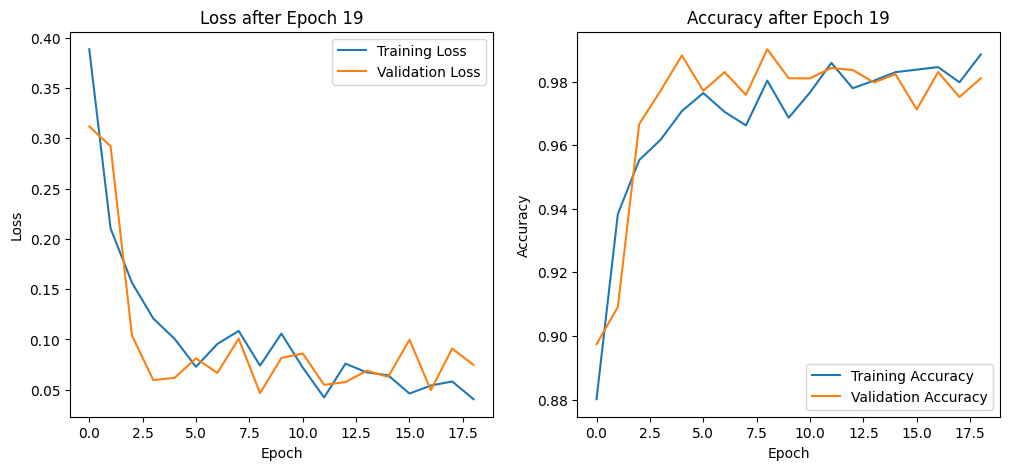

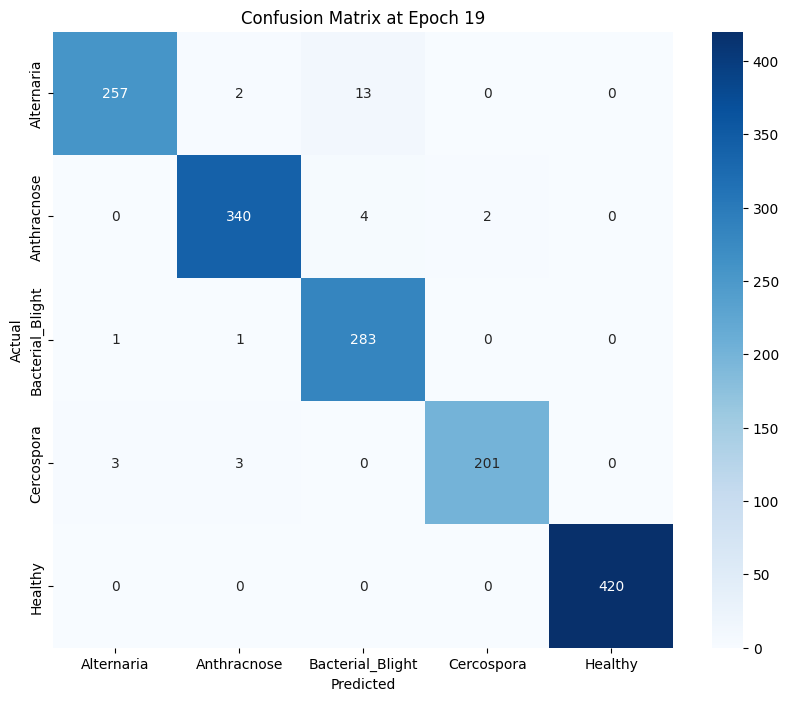

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_20.pth
Epoch : 20 Train Loss : 0.046209 Train Acc : 0.983814
Epoch 20/50 - Valid Loss: 0.0840, Accuracy: 0.9797, Precision: 0.9804, Recall: 0.9797, F1 Score: 0.9798


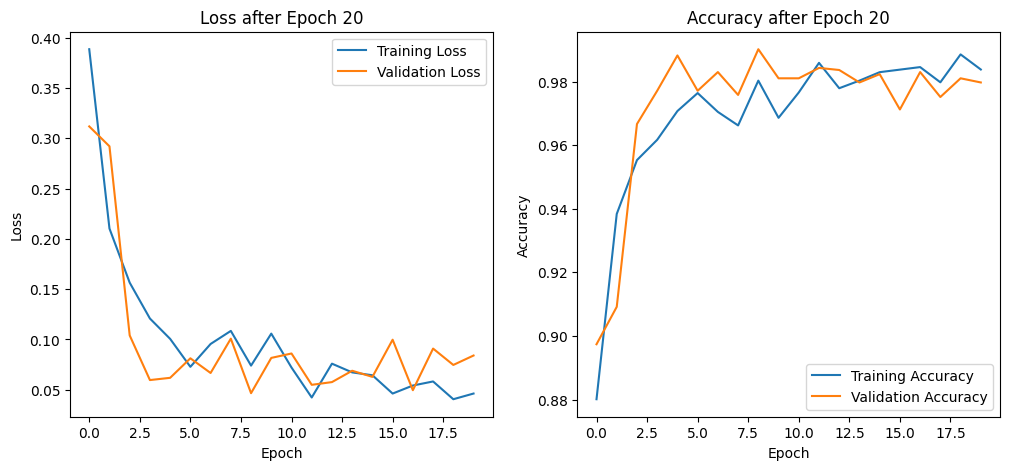

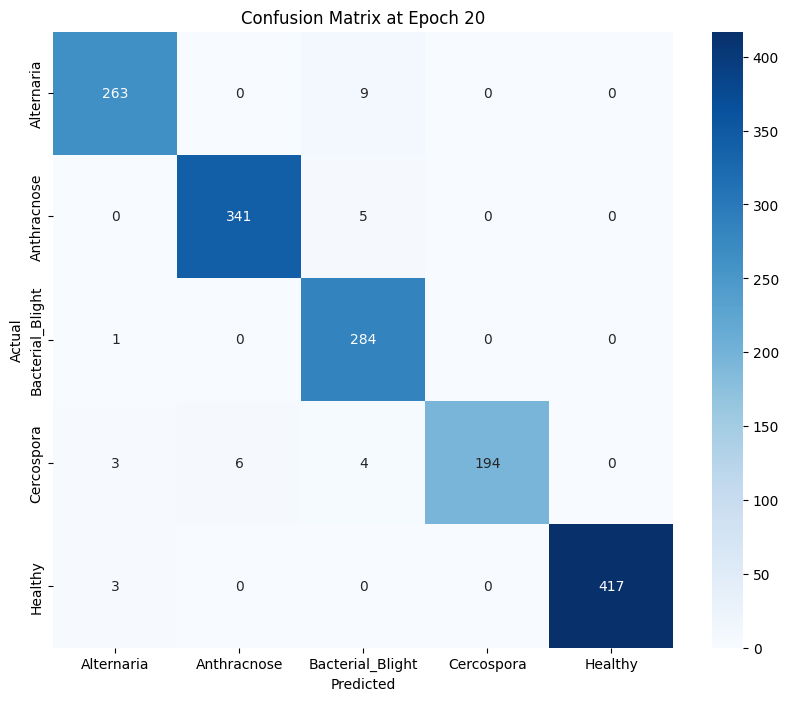

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_21.pth
Valid_loss decreased 0.0465607072027134 --> 0.02655293830399127
Epoch : 21 Train Loss : 0.016997 Train Acc : 0.993883
Epoch 21/50 - Valid Loss: 0.0266, Accuracy: 0.9935, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935


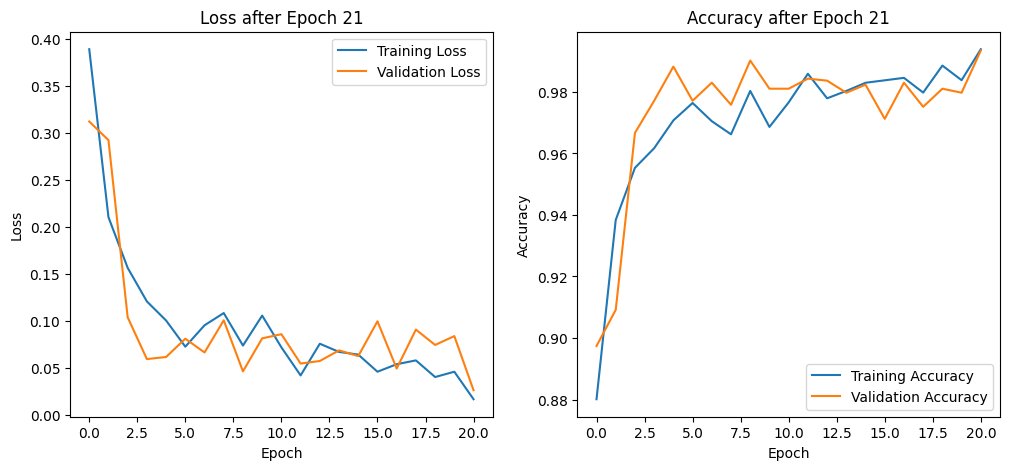

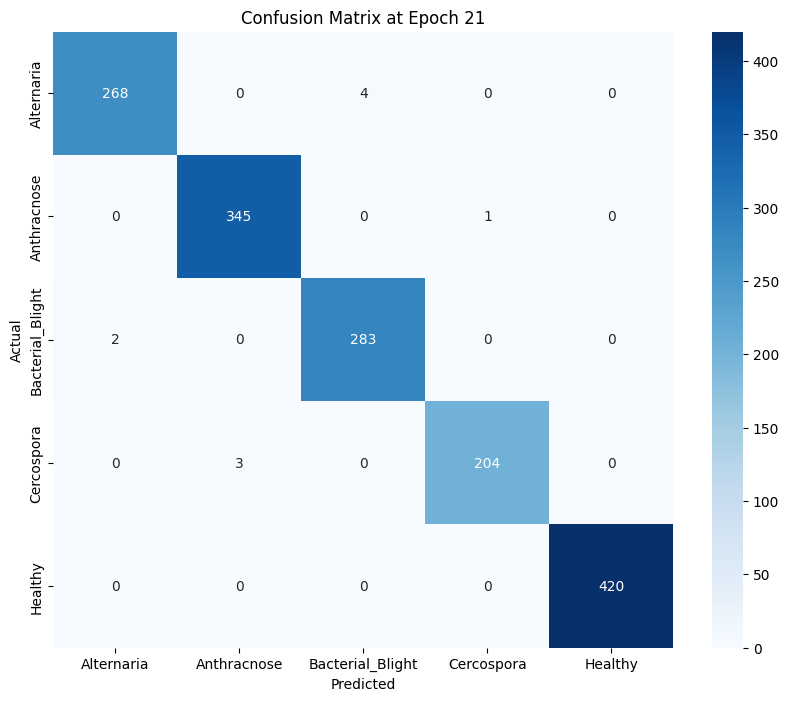

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_22.pth
Valid_loss decreased 0.02655293830399127 --> 0.02462022540347281
Epoch : 22 Train Loss : 0.013242 Train Acc : 0.996277
Epoch 22/50 - Valid Loss: 0.0246, Accuracy: 0.9948, Precision: 0.9948, Recall: 0.9948, F1 Score: 0.9948


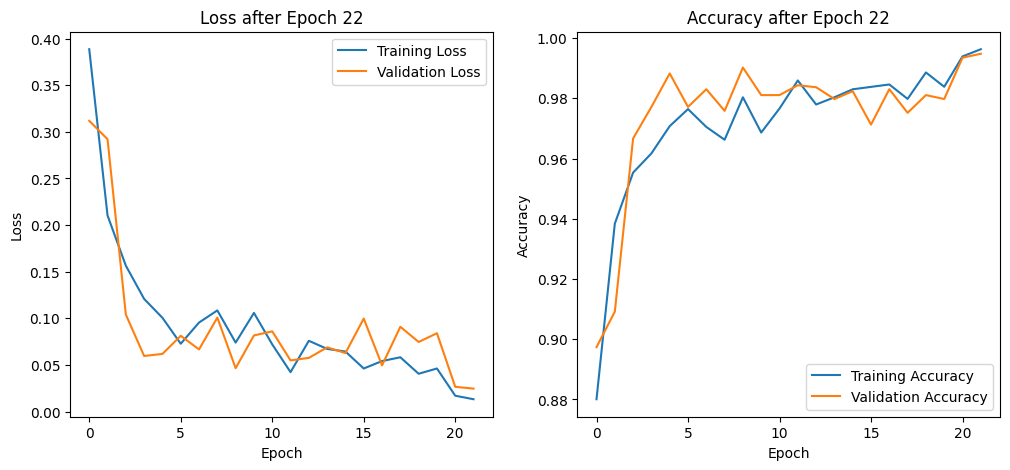

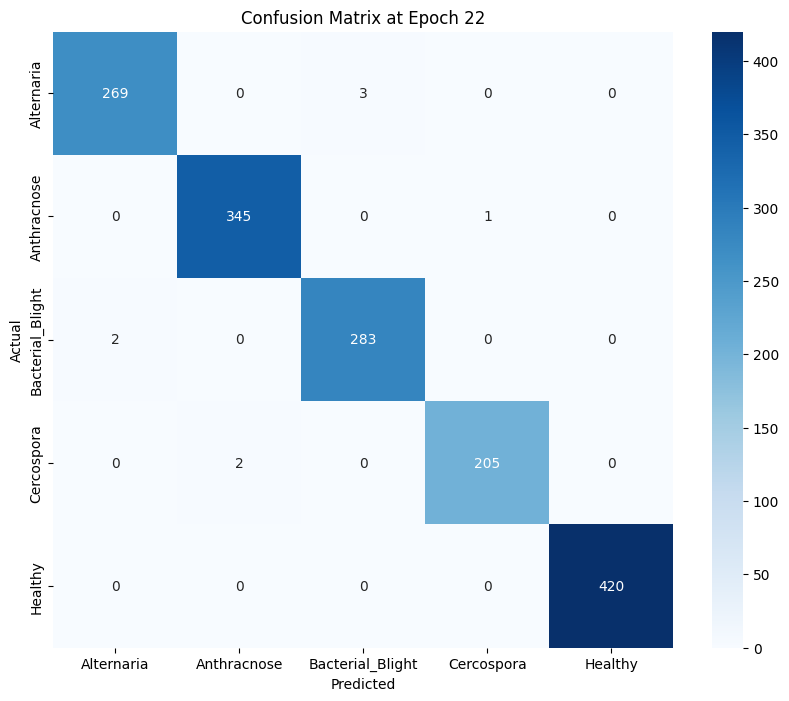

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_23.pth
Epoch : 23 Train Loss : 0.006811 Train Acc : 0.997074
Epoch 23/50 - Valid Loss: 0.0259, Accuracy: 0.9948, Precision: 0.9948, Recall: 0.9948, F1 Score: 0.9948


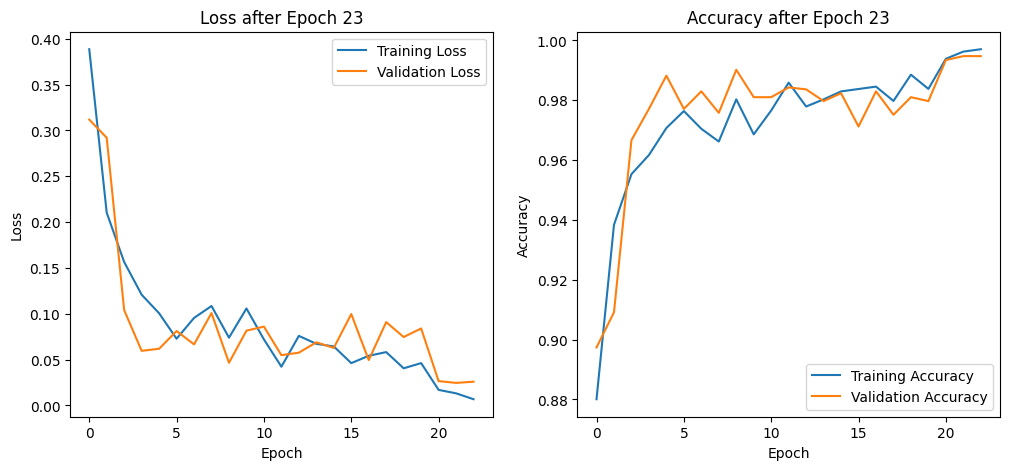

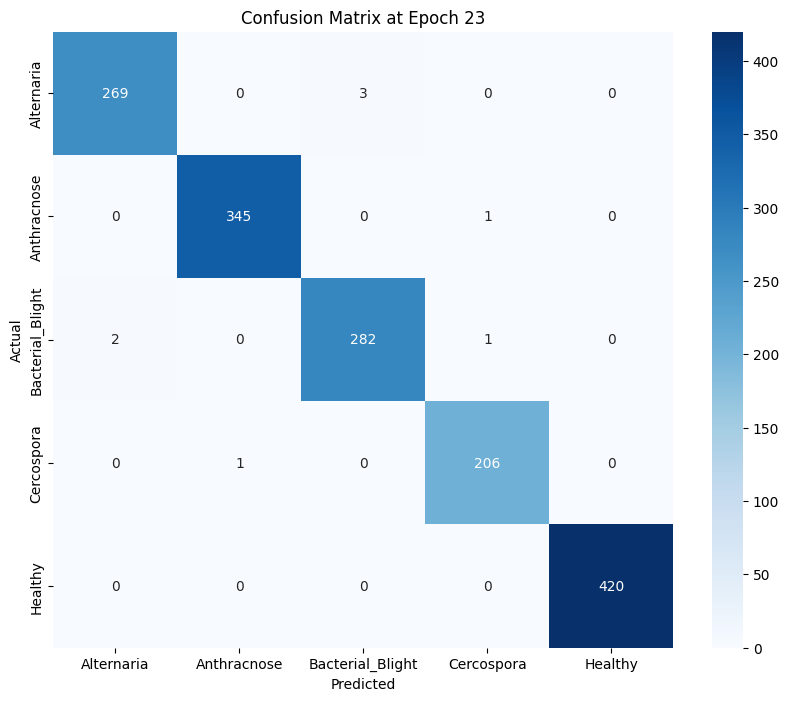

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_24.pth
Epoch : 24 Train Loss : 0.006107 Train Acc : 0.997606
Epoch 24/50 - Valid Loss: 0.0288, Accuracy: 0.9948, Precision: 0.9948, Recall: 0.9948, F1 Score: 0.9948


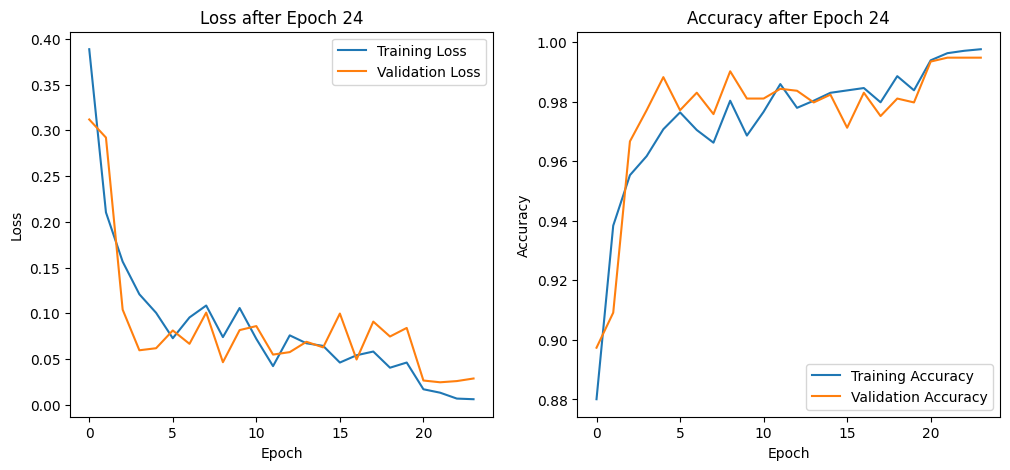

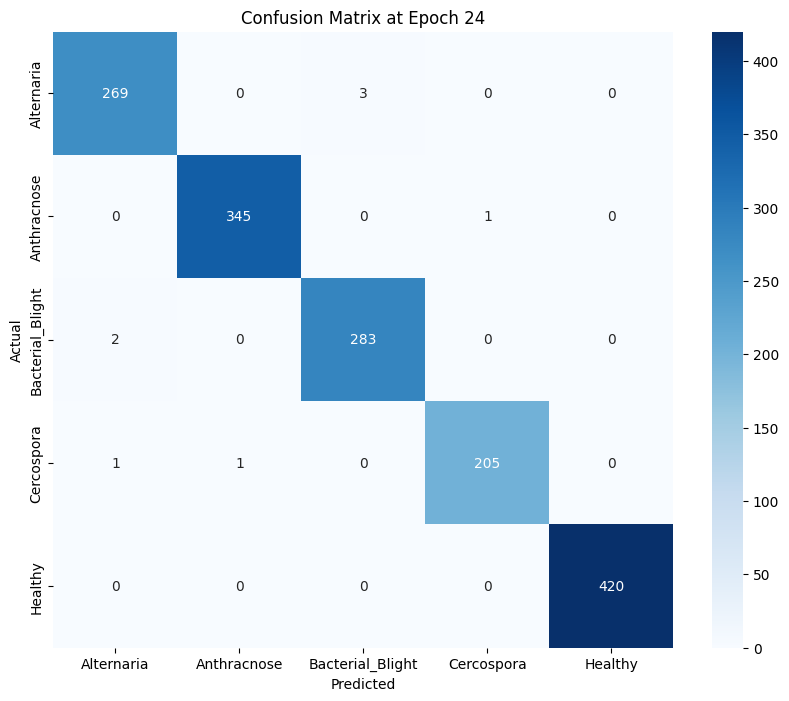

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_25.pth
Epoch : 25 Train Loss : 0.005258 Train Acc : 0.997910
Epoch 25/50 - Valid Loss: 0.0277, Accuracy: 0.9941, Precision: 0.9941, Recall: 0.9941, F1 Score: 0.9941


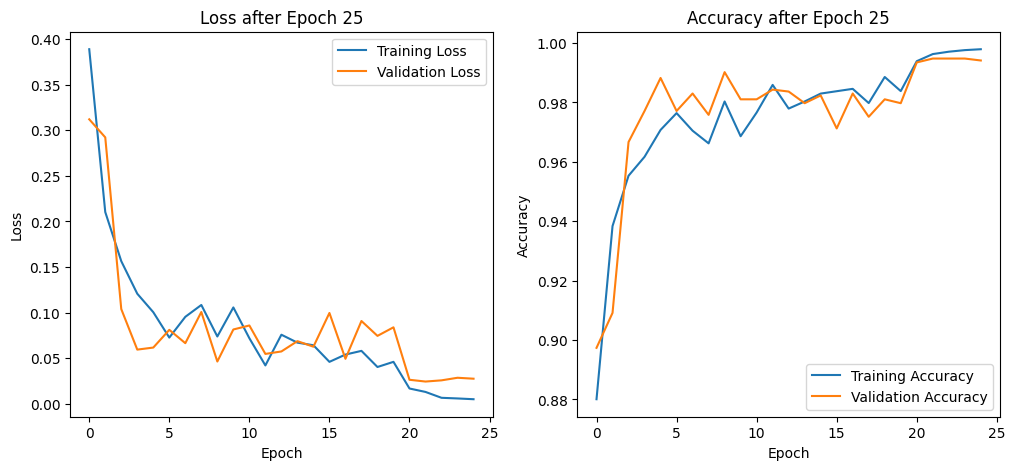

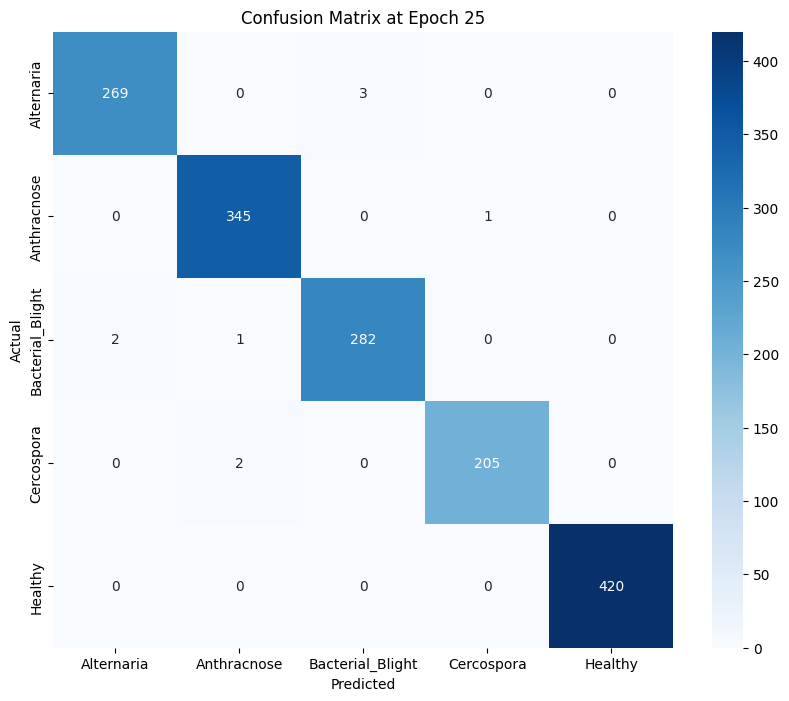

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_26.pth
Epoch : 26 Train Loss : 0.005136 Train Acc : 0.998138
Epoch 26/50 - Valid Loss: 0.0305, Accuracy: 0.9935, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935


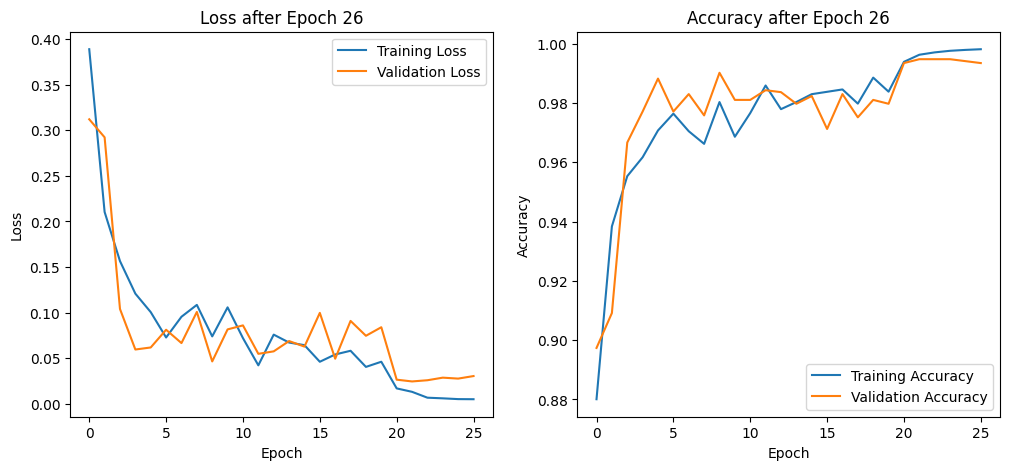

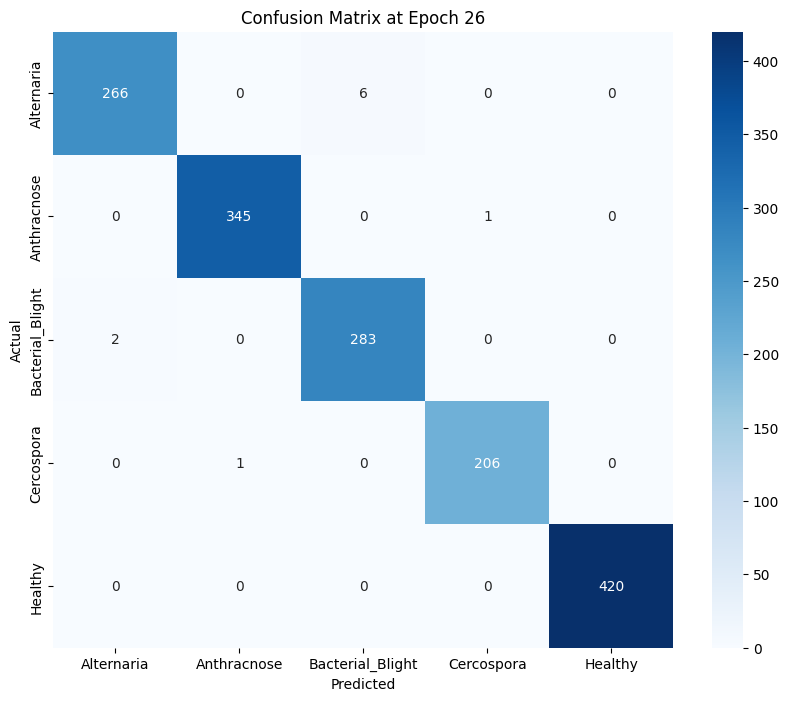

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_27.pth
Epoch : 27 Train Loss : 0.003377 Train Acc : 0.999202
Epoch 27/50 - Valid Loss: 0.0246, Accuracy: 0.9954, Precision: 0.9954, Recall: 0.9954, F1 Score: 0.9954


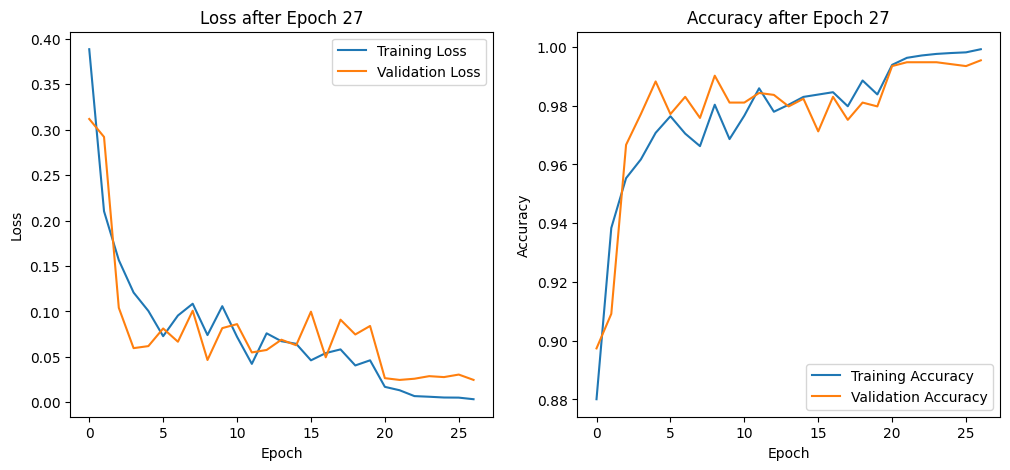

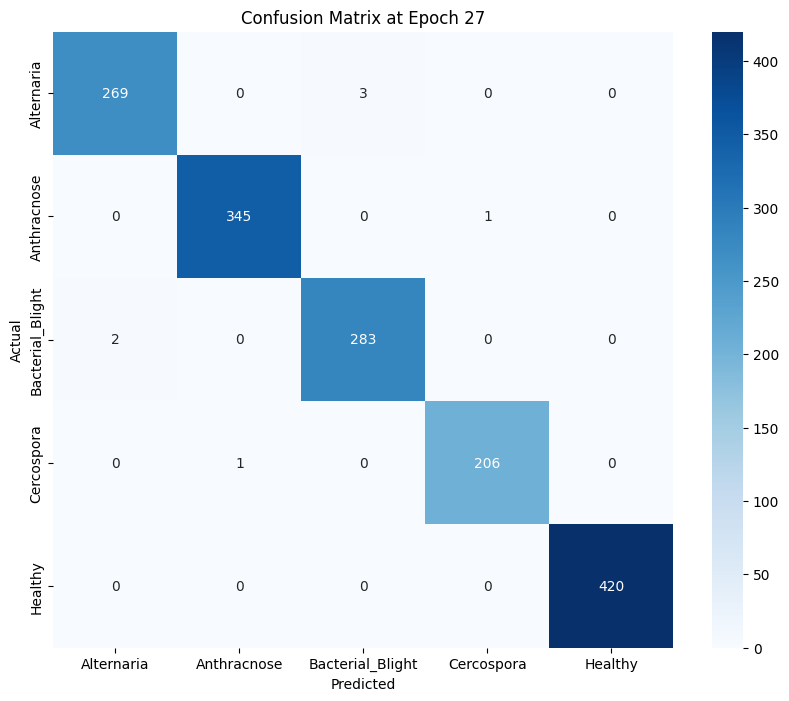

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_28.pth
Epoch : 28 Train Loss : 0.006295 Train Acc : 0.997872
Epoch 28/50 - Valid Loss: 0.0247, Accuracy: 0.9948, Precision: 0.9948, Recall: 0.9948, F1 Score: 0.9948


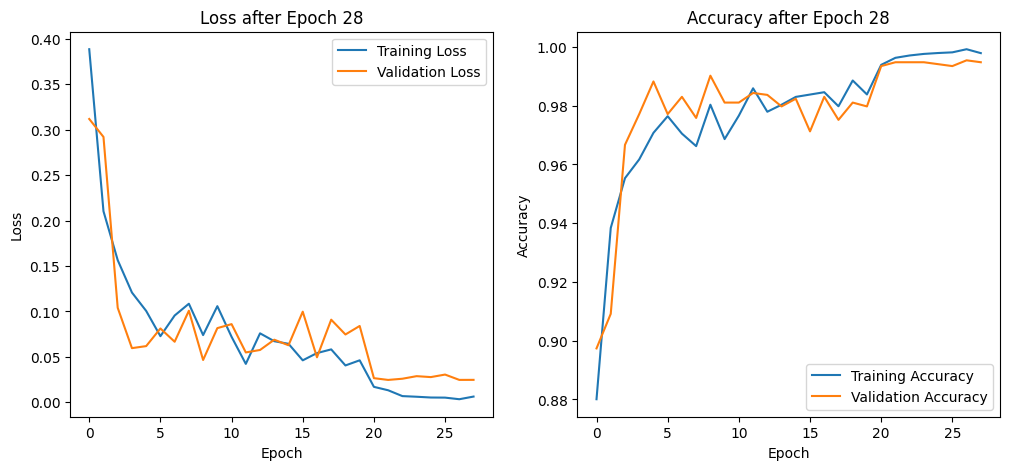

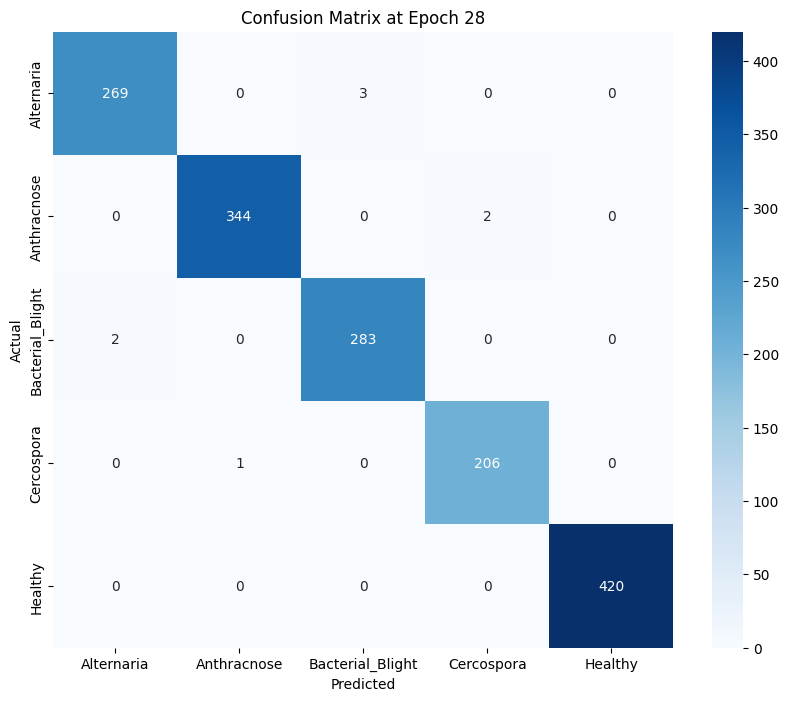

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_29.pth
Valid_loss decreased 0.02462022540347281 --> 0.02384614786149234
Epoch : 29 Train Loss : 0.005680 Train Acc : 0.998138
Epoch 29/50 - Valid Loss: 0.0238, Accuracy: 0.9954, Precision: 0.9954, Recall: 0.9954, F1 Score: 0.9954


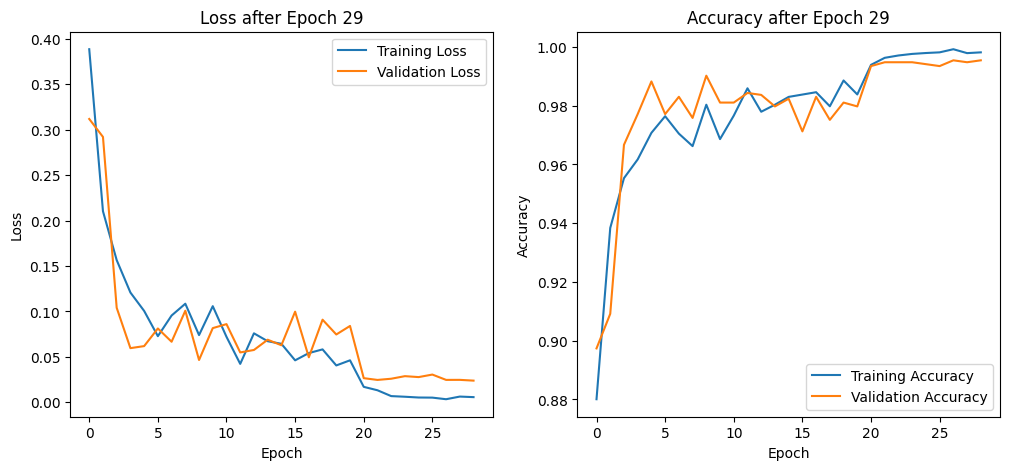

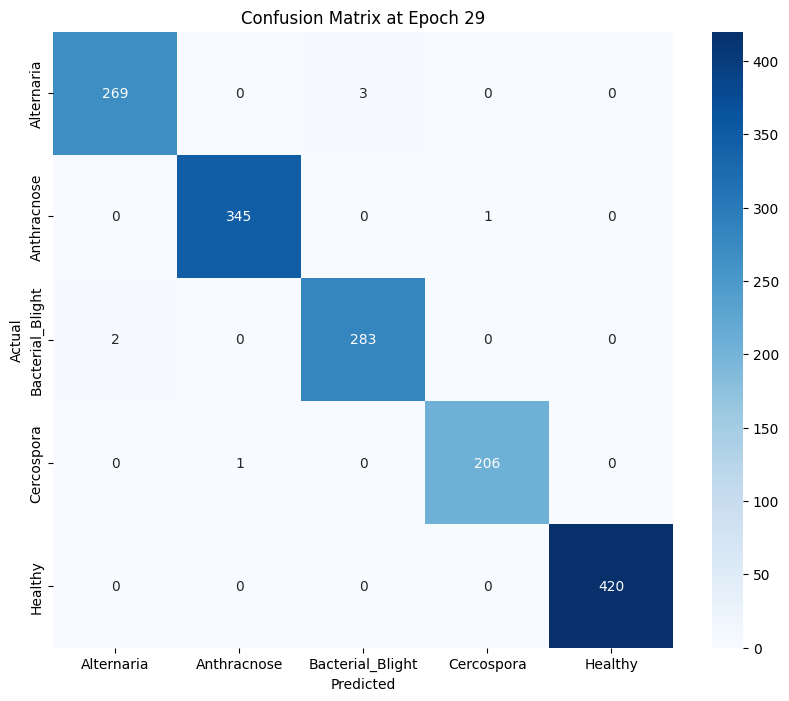

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_30.pth
Epoch : 30 Train Loss : 0.003556 Train Acc : 0.998936
Epoch 30/50 - Valid Loss: 0.0249, Accuracy: 0.9954, Precision: 0.9954, Recall: 0.9954, F1 Score: 0.9954


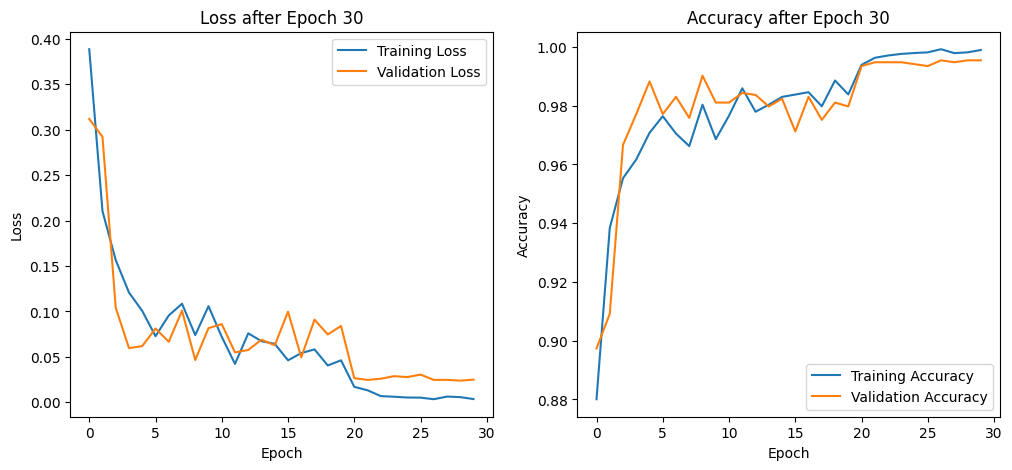

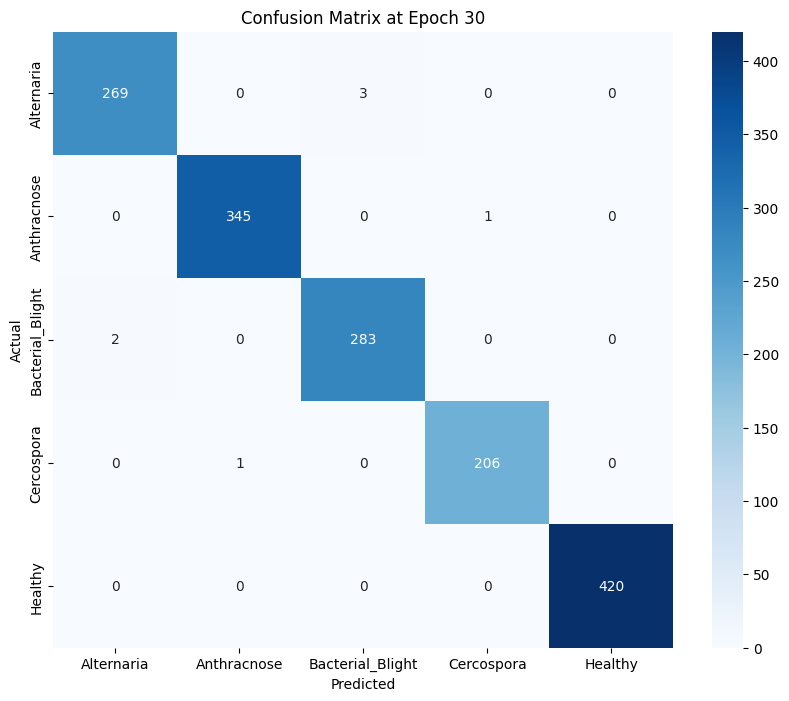

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_31.pth
Epoch : 31 Train Loss : 0.002191 Train Acc : 0.999734
Epoch 31/50 - Valid Loss: 0.0298, Accuracy: 0.9954, Precision: 0.9954, Recall: 0.9954, F1 Score: 0.9954


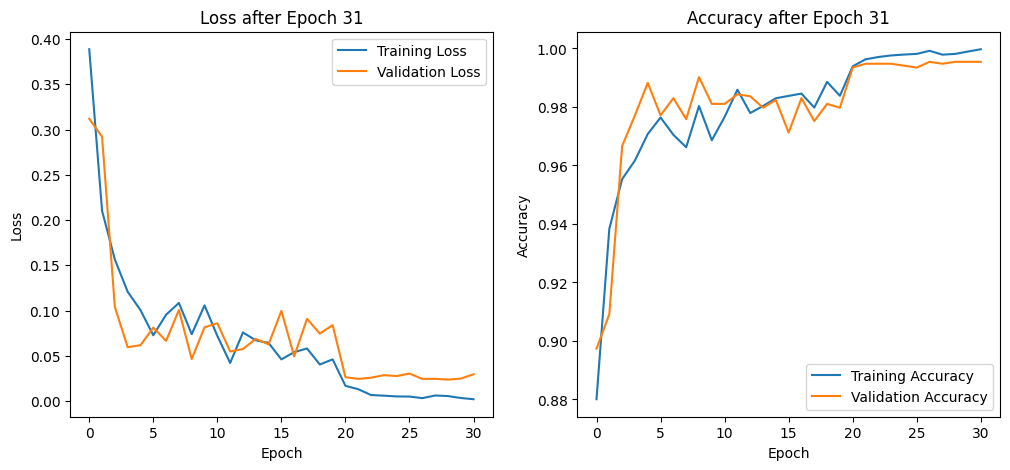

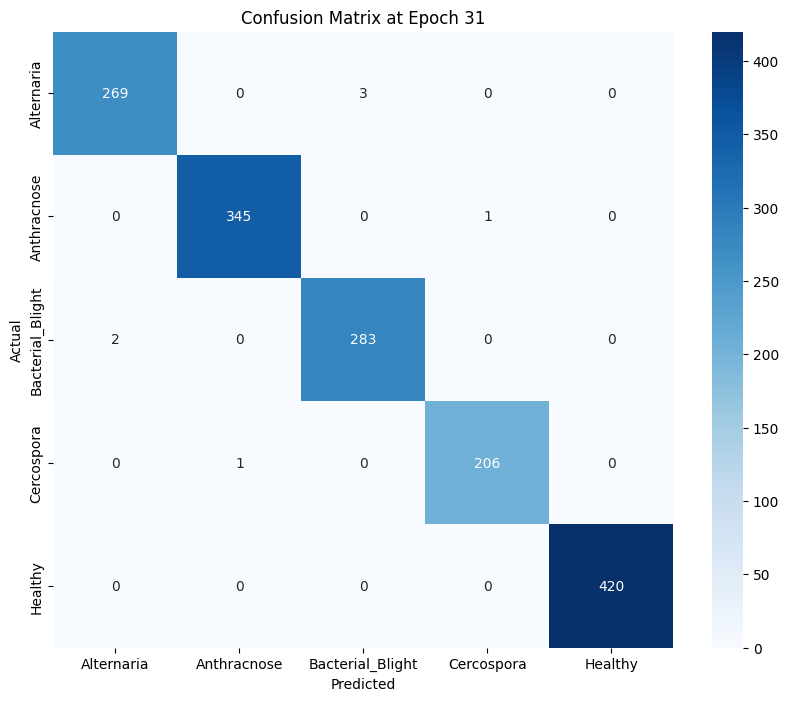

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_32.pth
Epoch : 32 Train Loss : 0.003312 Train Acc : 0.998670
Epoch 32/50 - Valid Loss: 0.0306, Accuracy: 0.9948, Precision: 0.9948, Recall: 0.9948, F1 Score: 0.9948


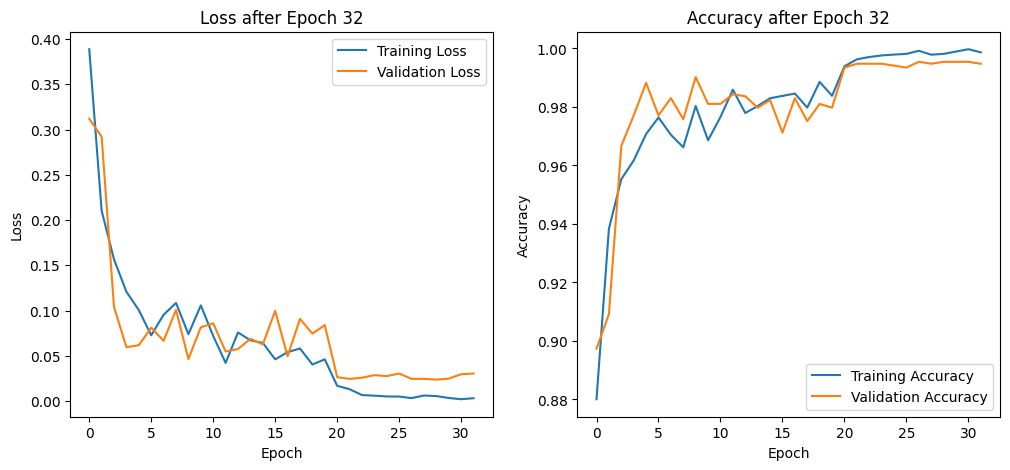

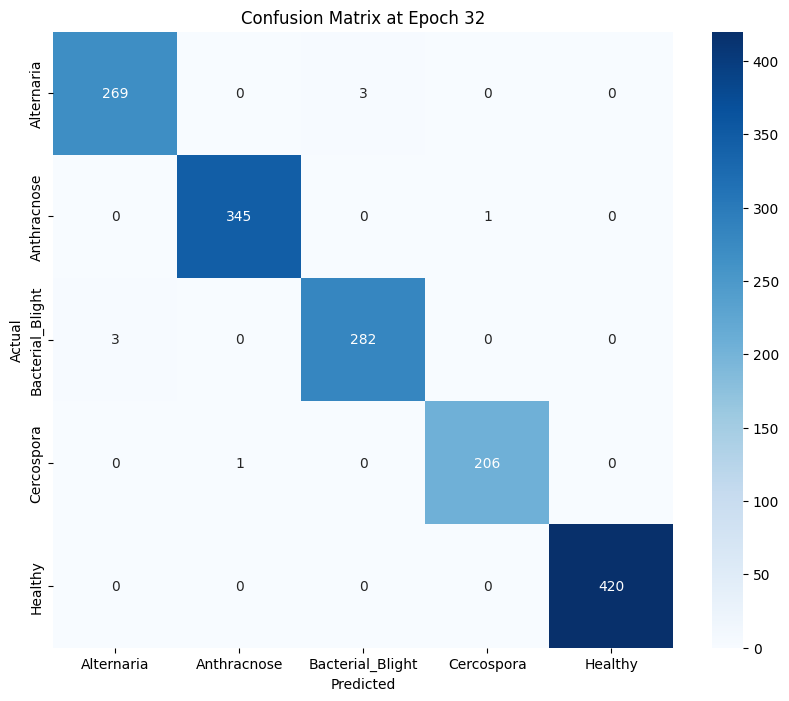

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_33.pth
Epoch : 33 Train Loss : 0.003969 Train Acc : 0.998670
Epoch 33/50 - Valid Loss: 0.0346, Accuracy: 0.9928, Precision: 0.9929, Recall: 0.9928, F1 Score: 0.9928


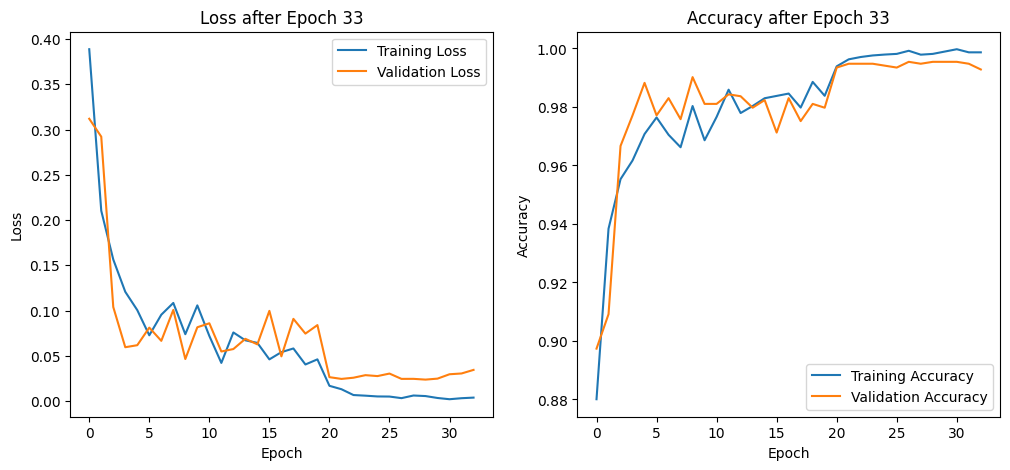

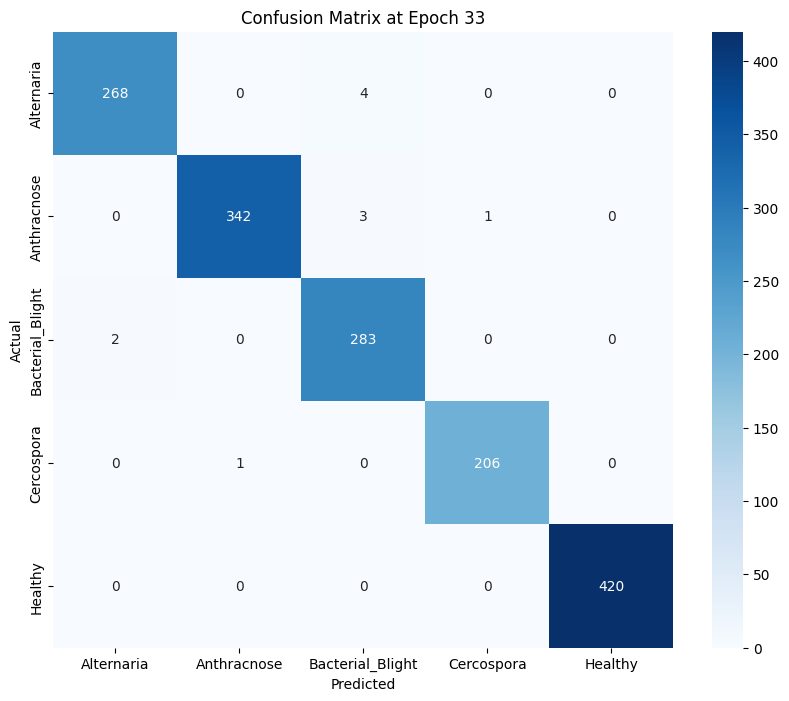

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_34.pth
Epoch : 34 Train Loss : 0.004030 Train Acc : 0.998936
Epoch 34/50 - Valid Loss: 0.0435, Accuracy: 0.9928, Precision: 0.9929, Recall: 0.9928, F1 Score: 0.9928


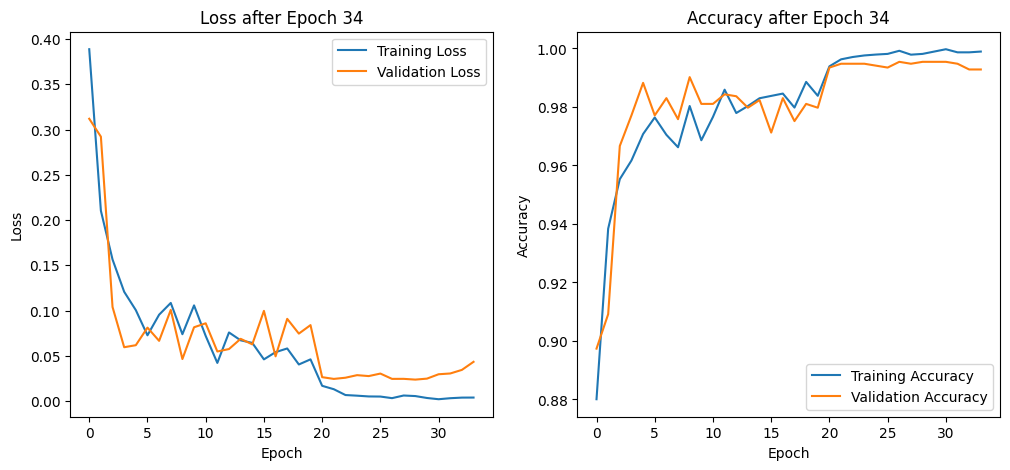

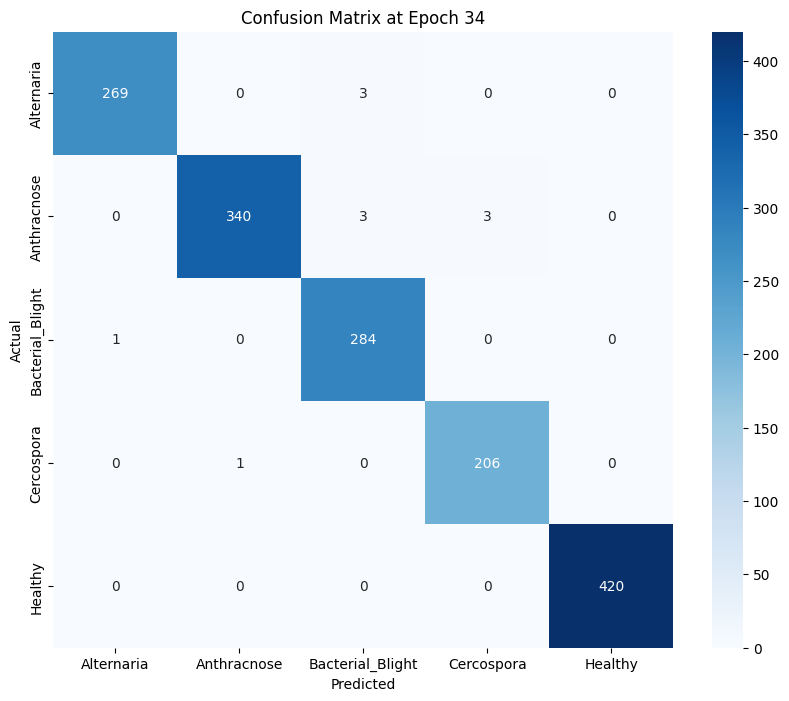

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_35.pth
Epoch : 35 Train Loss : 0.001232 Train Acc : 1.000000
Epoch 35/50 - Valid Loss: 0.0340, Accuracy: 0.9935, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935


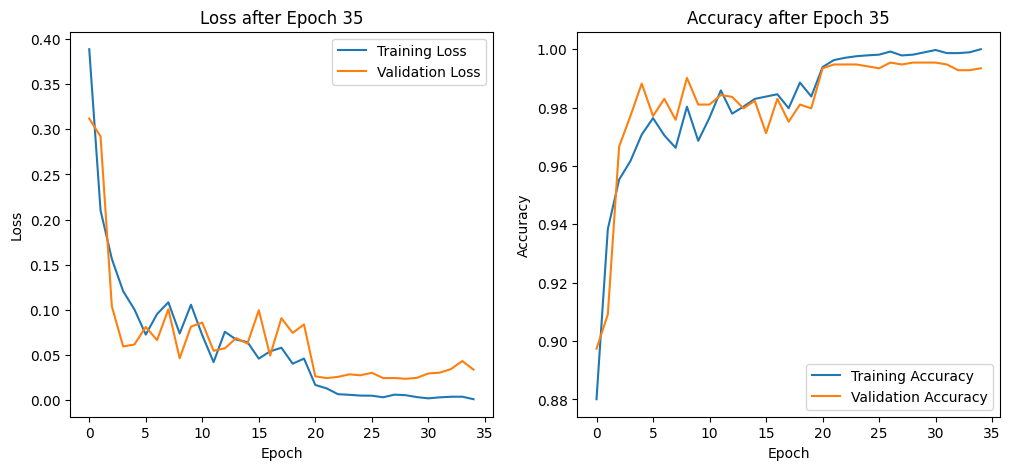

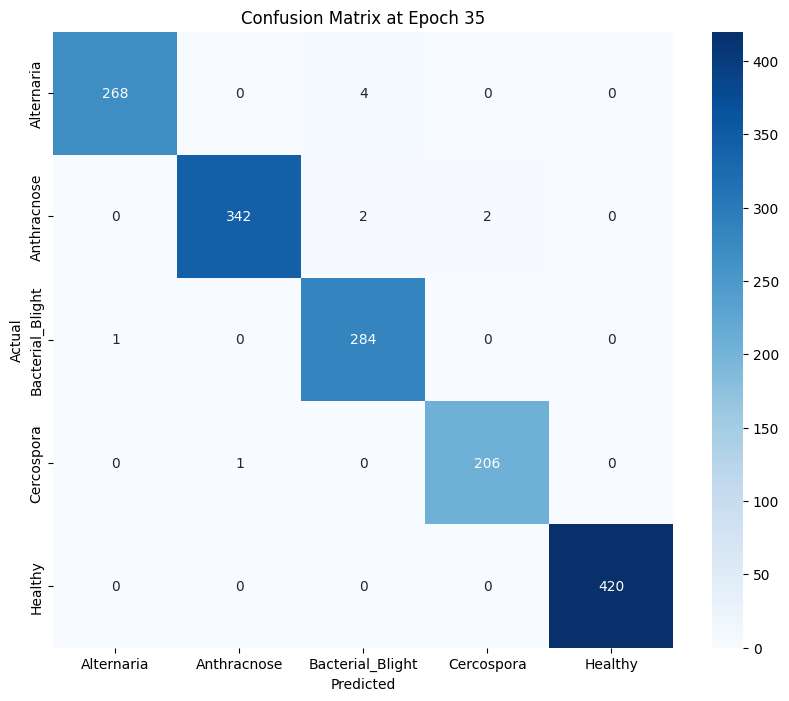

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_36.pth
Epoch : 36 Train Loss : 0.001753 Train Acc : 0.999202
Epoch 36/50 - Valid Loss: 0.0362, Accuracy: 0.9935, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935


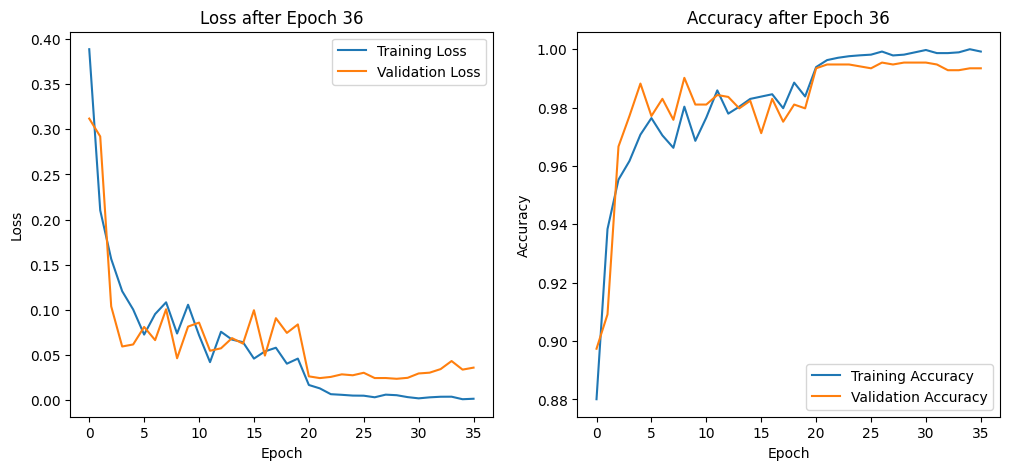

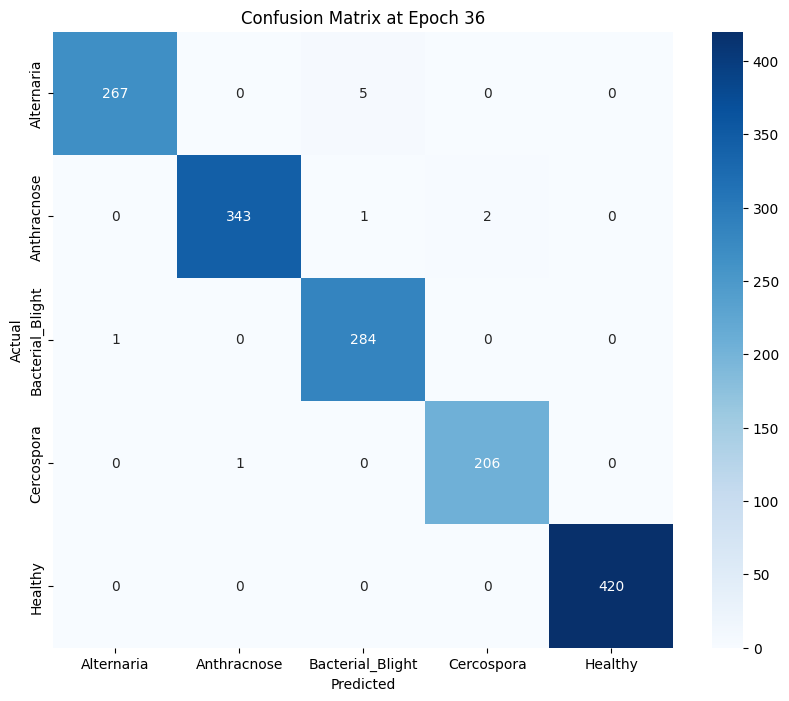

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_37.pth
Epoch : 37 Train Loss : 0.002109 Train Acc : 0.999202
Epoch 37/50 - Valid Loss: 0.0386, Accuracy: 0.9941, Precision: 0.9942, Recall: 0.9941, F1 Score: 0.9941


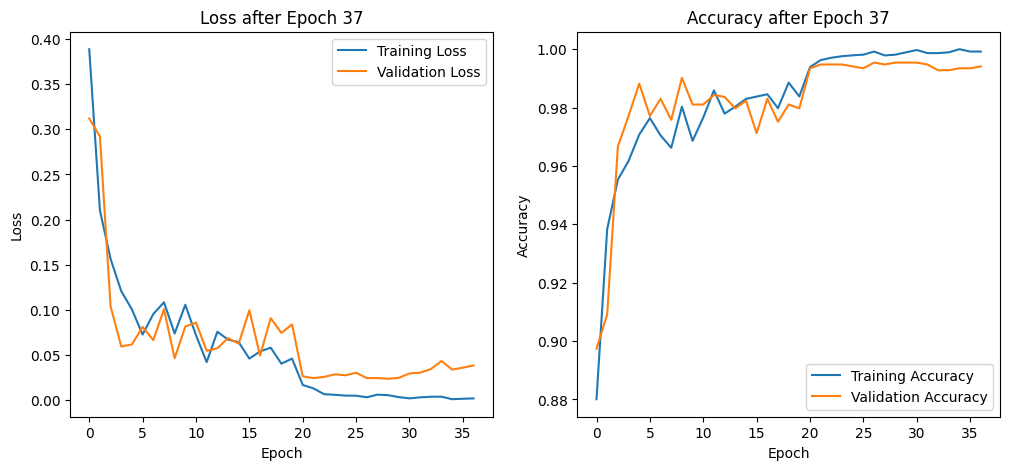

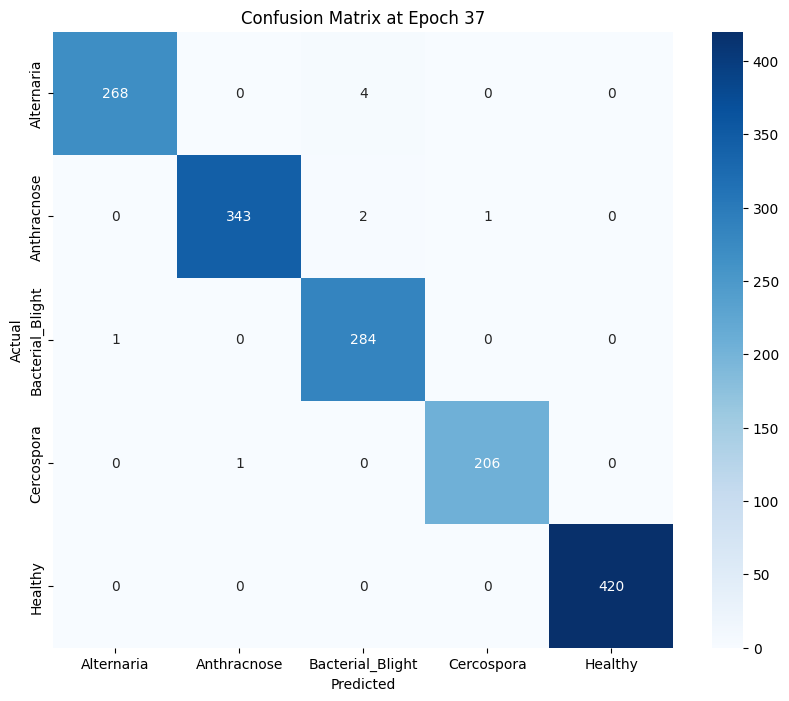

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_38.pth
Epoch : 38 Train Loss : 0.002581 Train Acc : 0.999202
Epoch 38/50 - Valid Loss: 0.0376, Accuracy: 0.9954, Precision: 0.9954, Recall: 0.9954, F1 Score: 0.9954


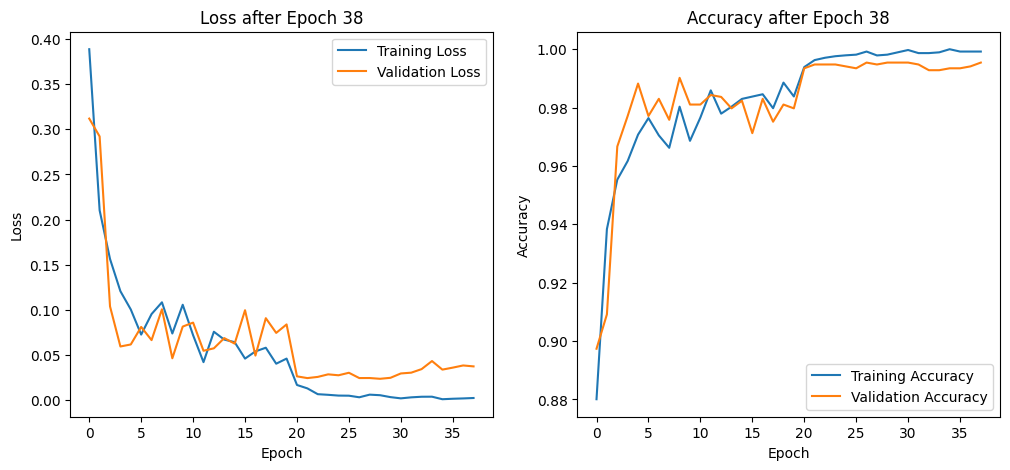

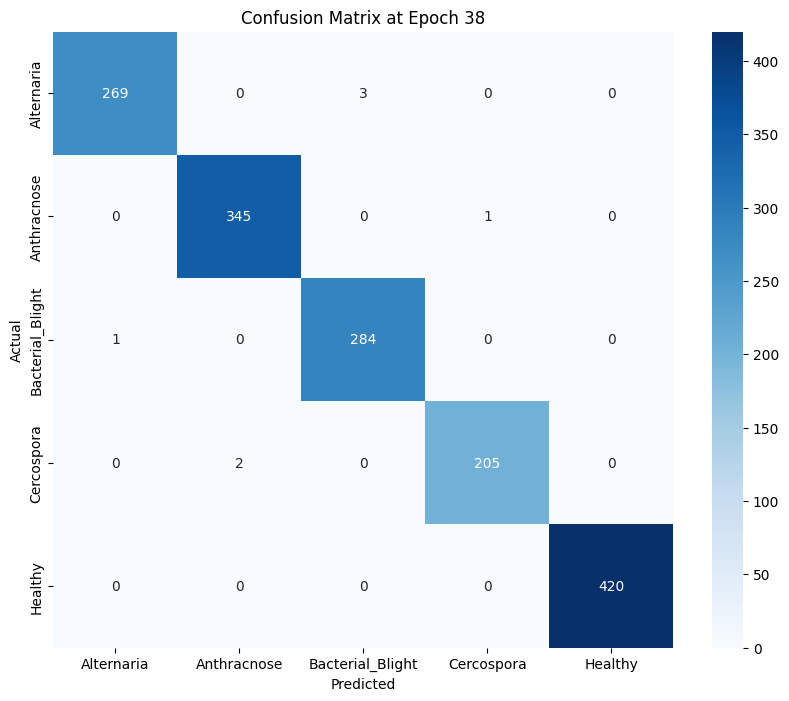

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_39.pth
Epoch : 39 Train Loss : 0.004184 Train Acc : 0.998670
Epoch 39/50 - Valid Loss: 0.0355, Accuracy: 0.9941, Precision: 0.9941, Recall: 0.9941, F1 Score: 0.9941


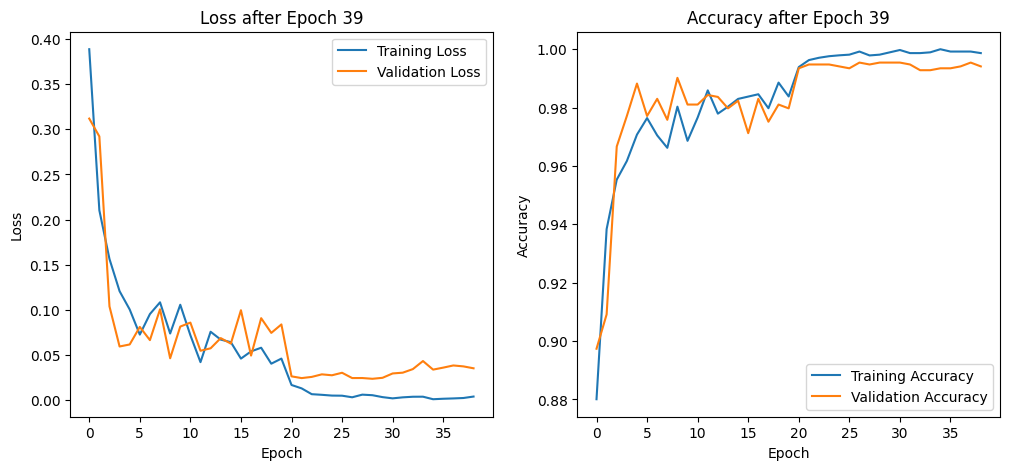

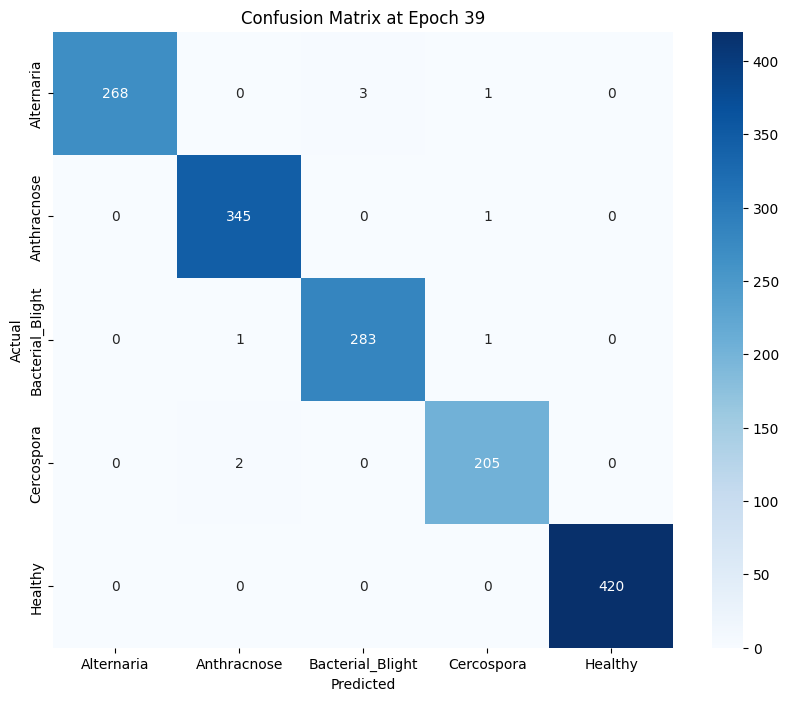

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_40.pth
Epoch : 40 Train Loss : 0.001475 Train Acc : 0.999734
Epoch 40/50 - Valid Loss: 0.0352, Accuracy: 0.9954, Precision: 0.9954, Recall: 0.9954, F1 Score: 0.9954


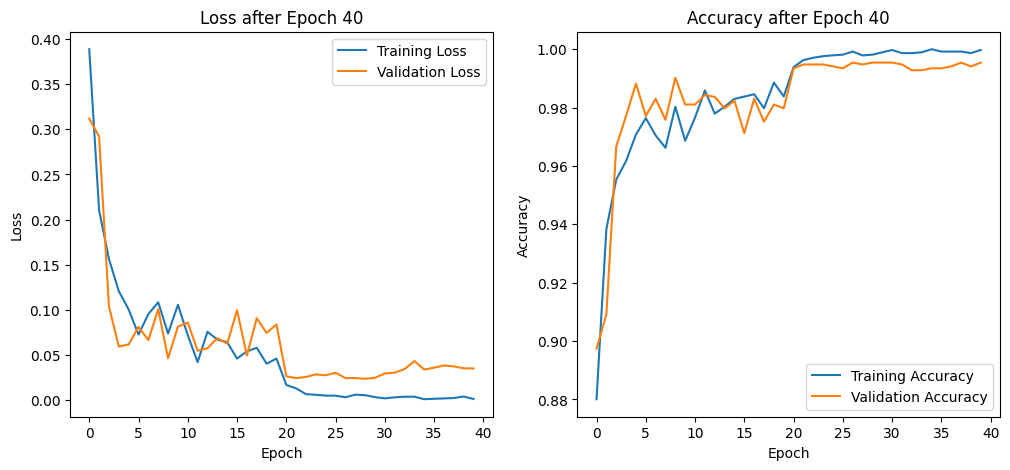

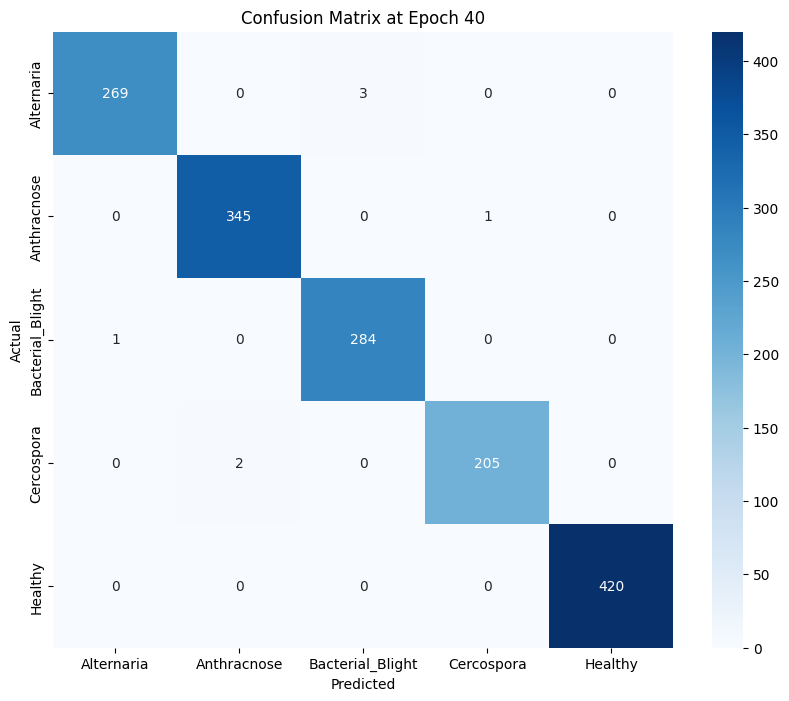

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_41.pth
Epoch : 41 Train Loss : 0.001381 Train Acc : 0.999734
Epoch 41/50 - Valid Loss: 0.0346, Accuracy: 0.9948, Precision: 0.9948, Recall: 0.9948, F1 Score: 0.9948


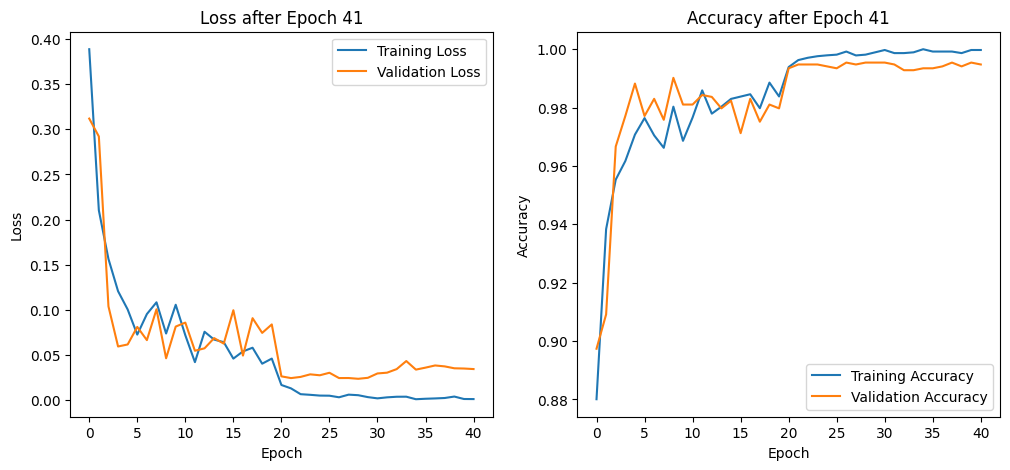

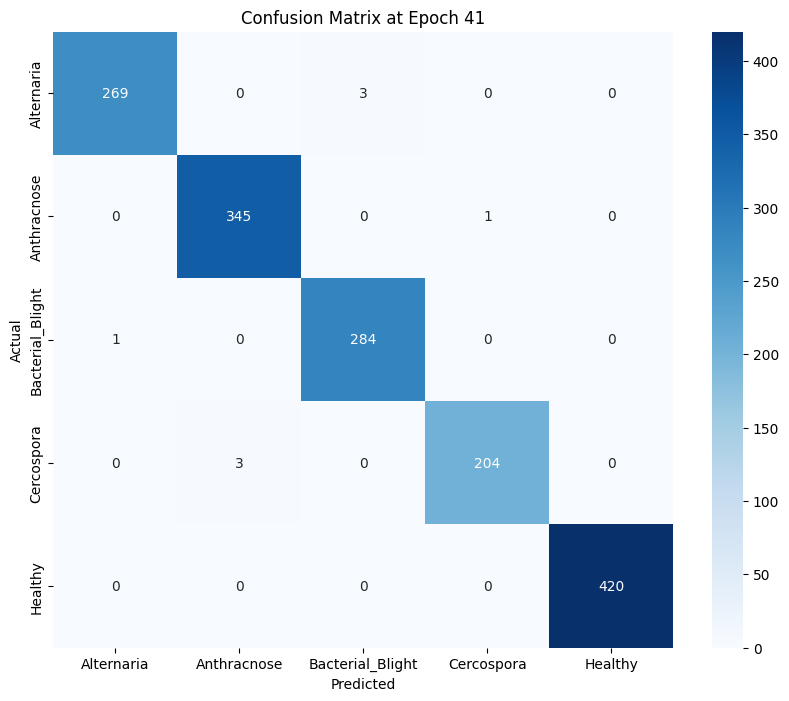

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_42.pth
Epoch : 42 Train Loss : 0.003549 Train Acc : 0.998176
Epoch 42/50 - Valid Loss: 0.0328, Accuracy: 0.9954, Precision: 0.9954, Recall: 0.9954, F1 Score: 0.9954


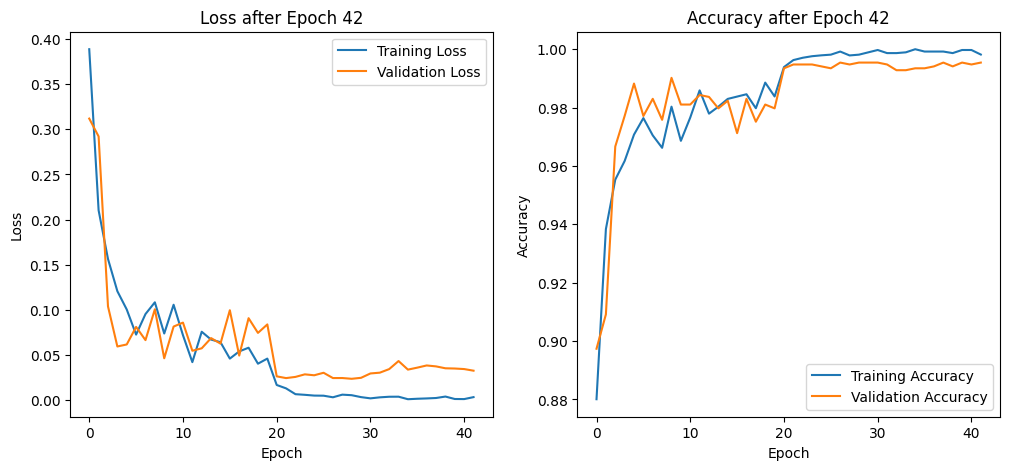

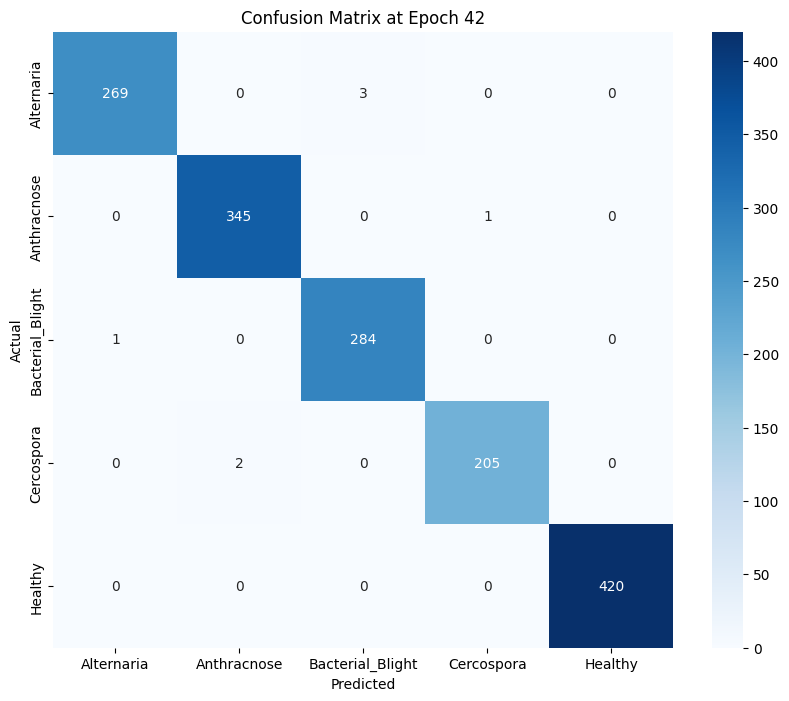

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_43.pth
Epoch : 43 Train Loss : 0.001770 Train Acc : 0.999734
Epoch 43/50 - Valid Loss: 0.0336, Accuracy: 0.9954, Precision: 0.9954, Recall: 0.9954, F1 Score: 0.9954


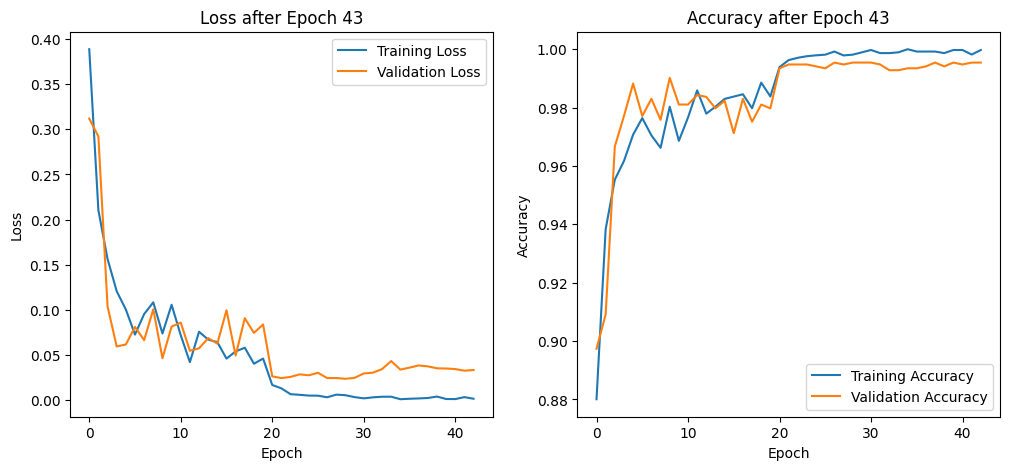

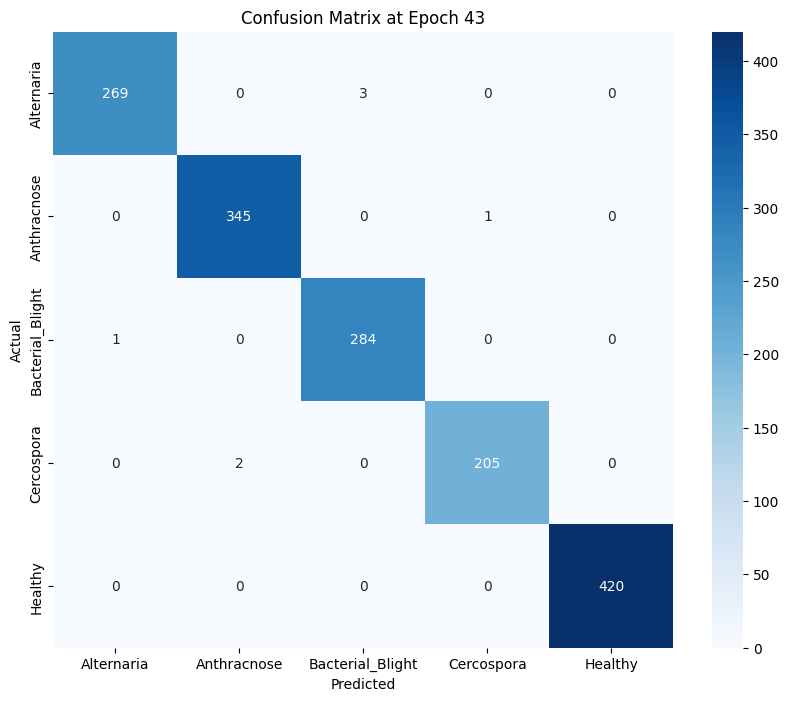

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_44.pth
Epoch : 44 Train Loss : 0.001109 Train Acc : 0.999734
Epoch 44/50 - Valid Loss: 0.0323, Accuracy: 0.9954, Precision: 0.9954, Recall: 0.9954, F1 Score: 0.9954


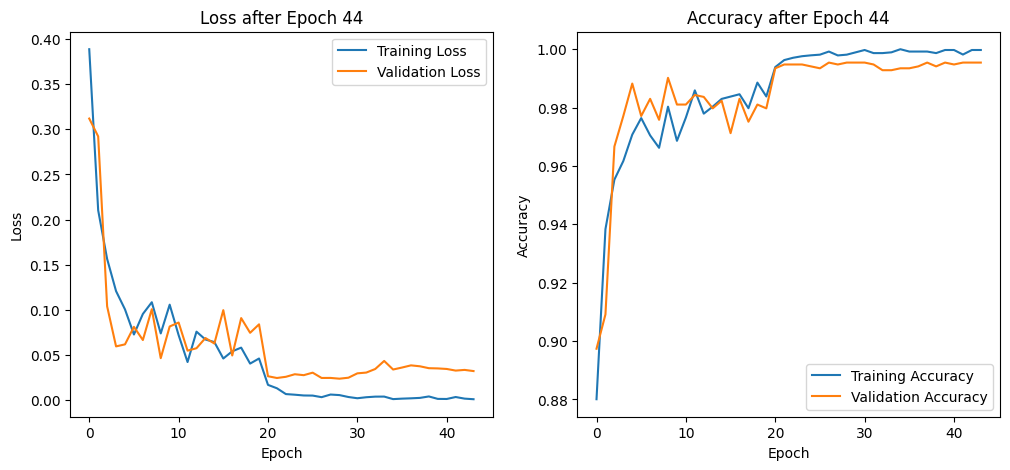

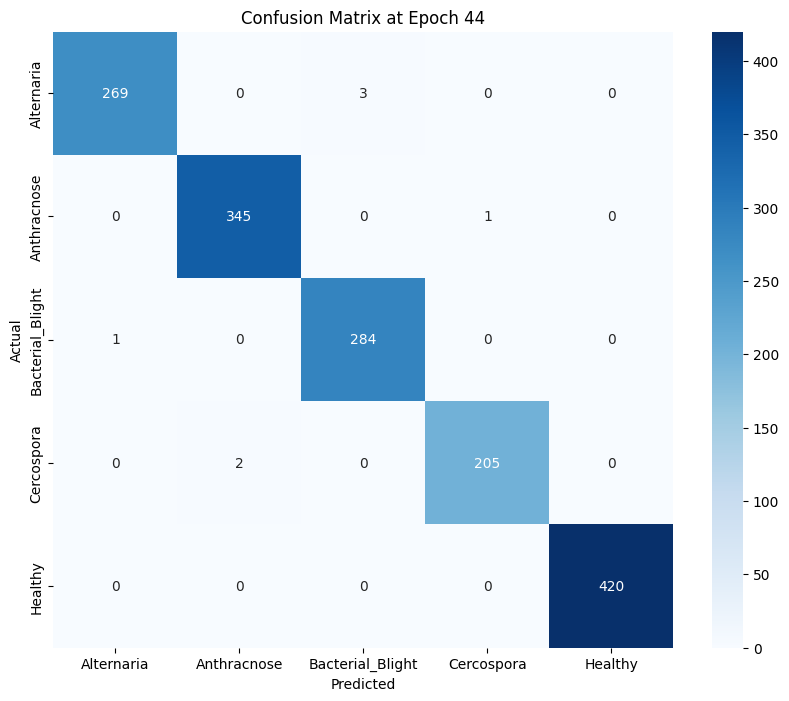

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_45.pth
Epoch : 45 Train Loss : 0.001051 Train Acc : 1.000000
Epoch 45/50 - Valid Loss: 0.0342, Accuracy: 0.9948, Precision: 0.9948, Recall: 0.9948, F1 Score: 0.9948


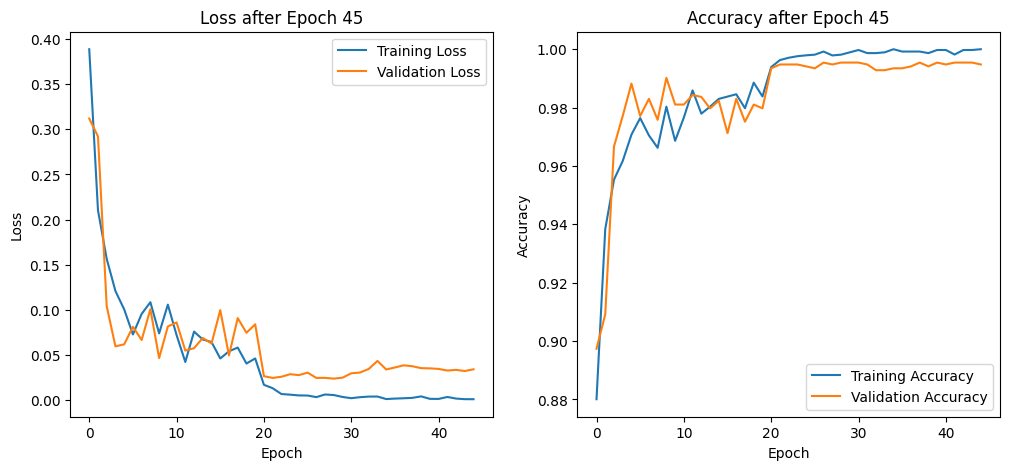

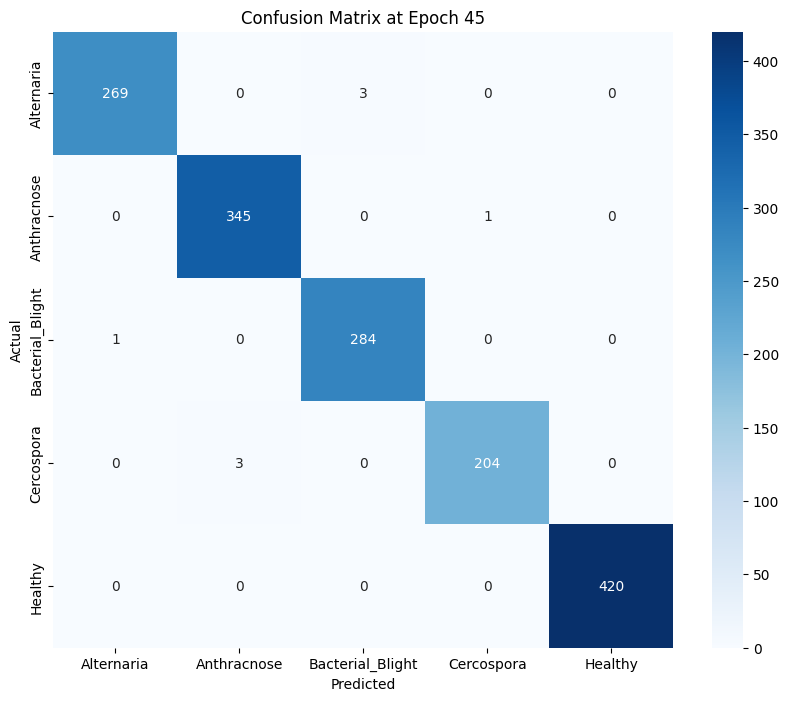

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_46.pth
Epoch : 46 Train Loss : 0.001569 Train Acc : 0.999468
Epoch 46/50 - Valid Loss: 0.0328, Accuracy: 0.9948, Precision: 0.9948, Recall: 0.9948, F1 Score: 0.9948


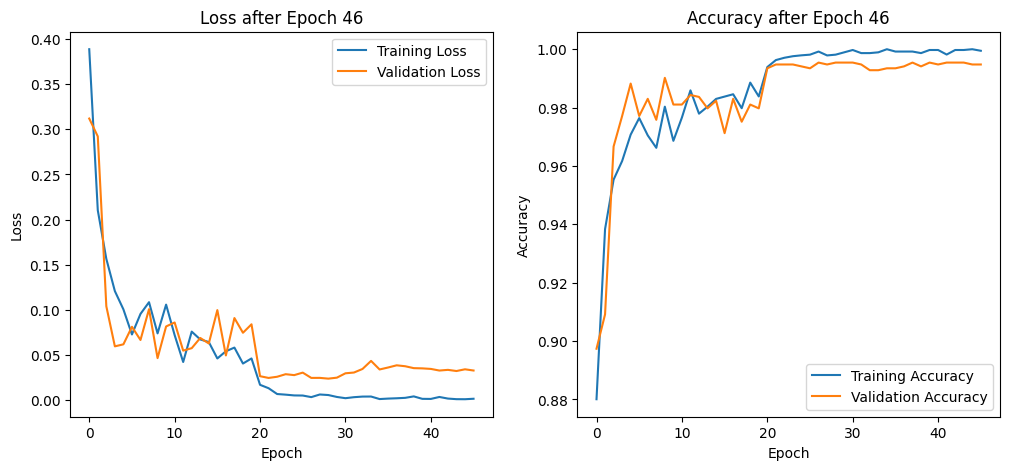

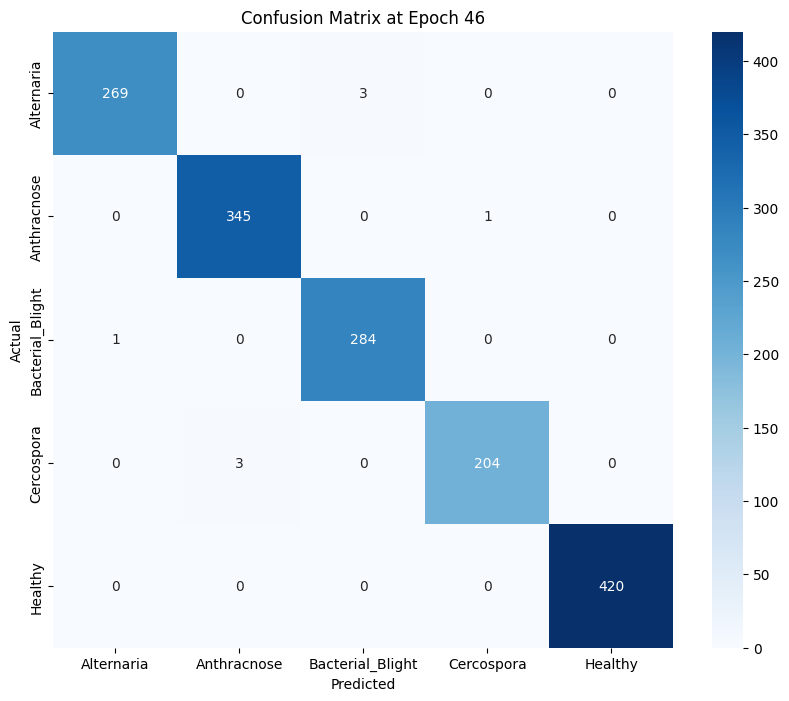

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_47.pth
Epoch : 47 Train Loss : 0.002413 Train Acc : 0.998974
Epoch 47/50 - Valid Loss: 0.0311, Accuracy: 0.9954, Precision: 0.9954, Recall: 0.9954, F1 Score: 0.9954


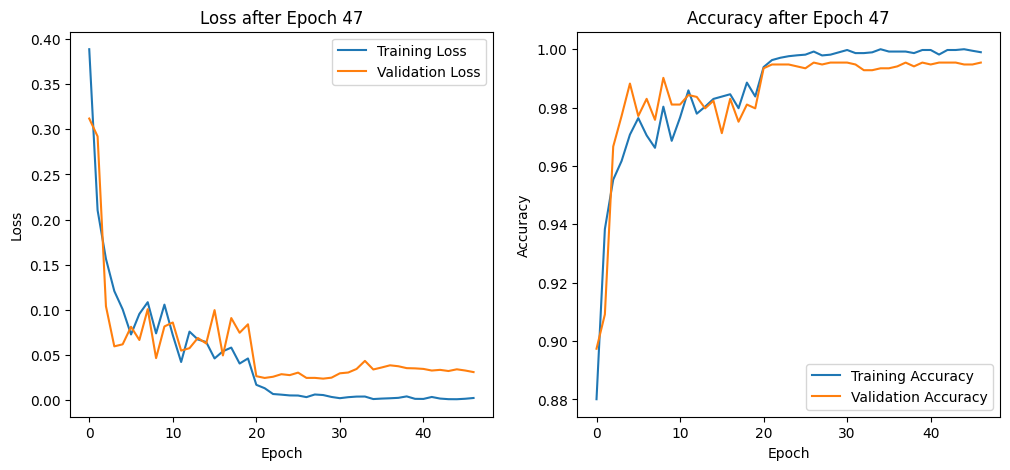

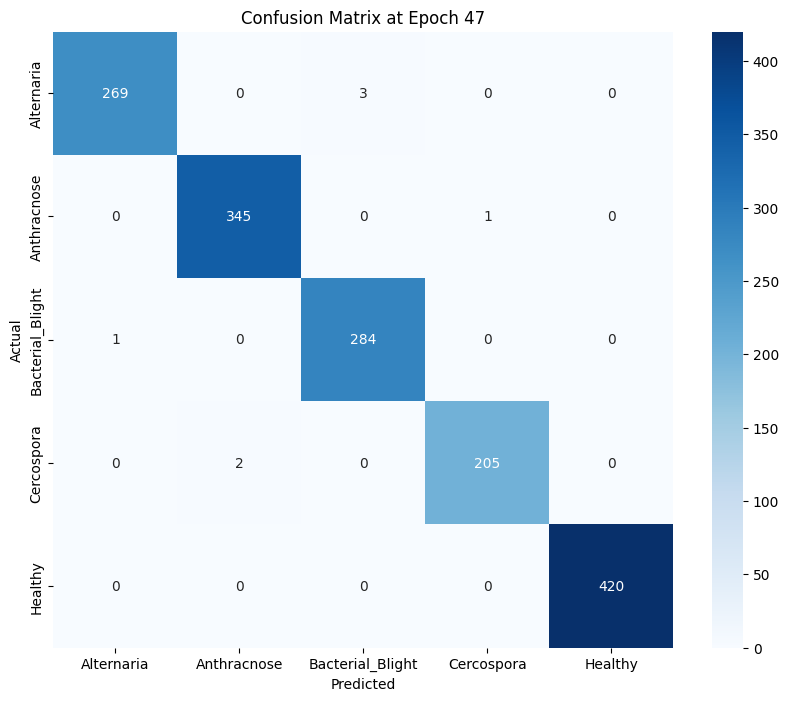

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_48.pth
Epoch : 48 Train Loss : 0.000323 Train Acc : 1.000000
Epoch 48/50 - Valid Loss: 0.0331, Accuracy: 0.9948, Precision: 0.9948, Recall: 0.9948, F1 Score: 0.9948


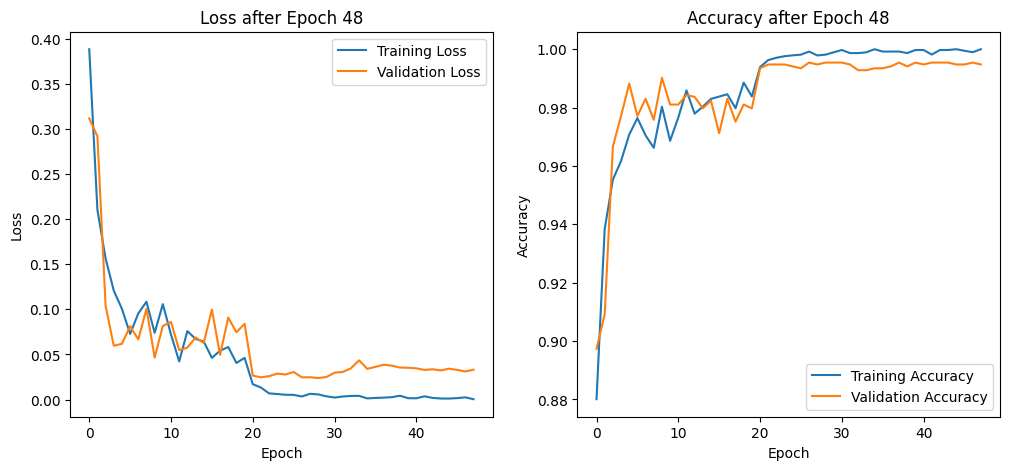

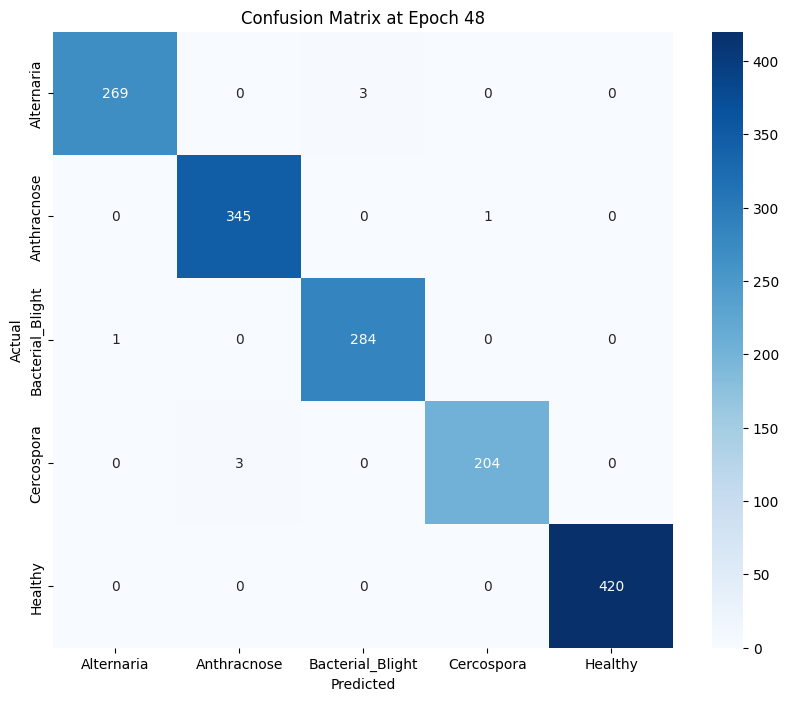

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_49.pth
Epoch : 49 Train Loss : 0.001072 Train Acc : 0.999734
Epoch 49/50 - Valid Loss: 0.0343, Accuracy: 0.9948, Precision: 0.9948, Recall: 0.9948, F1 Score: 0.9948


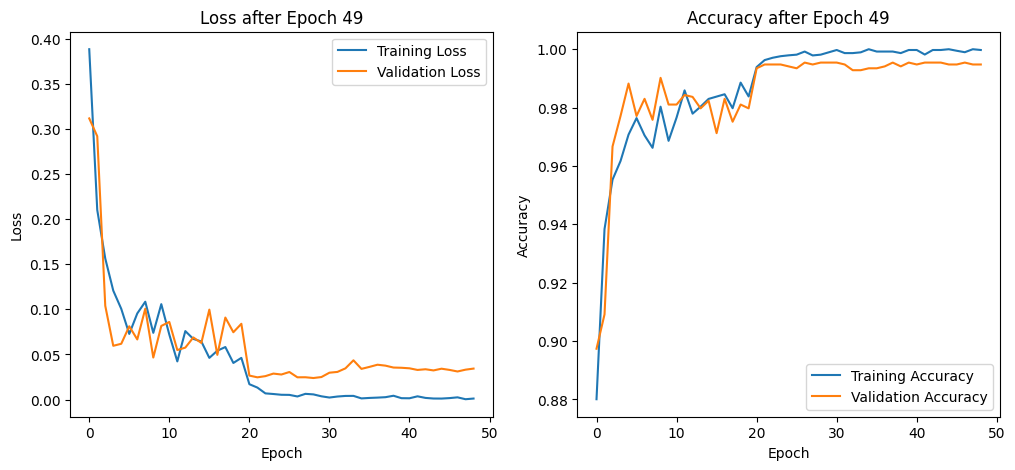

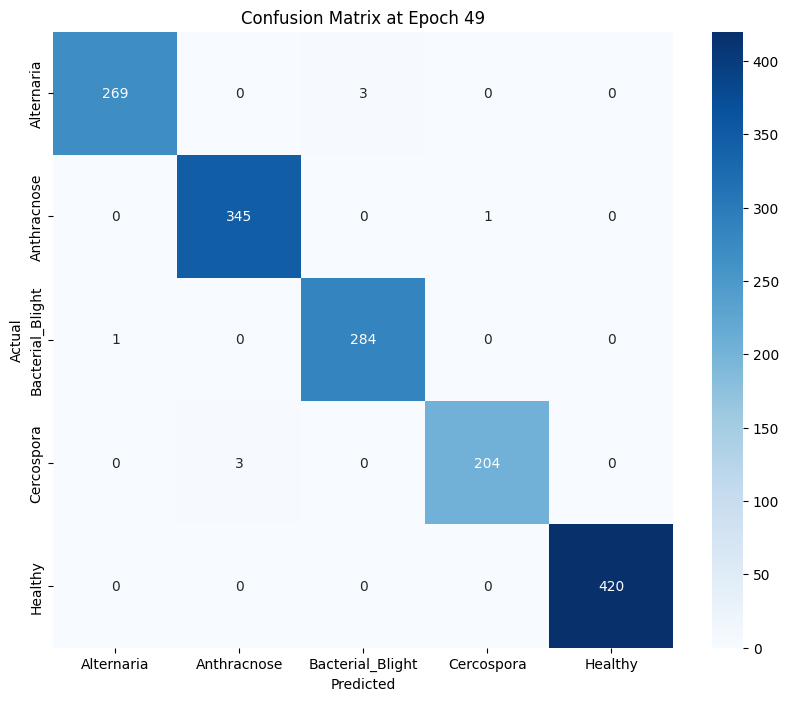

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as EfficientNet_M_Epoch_50.pth
Epoch : 50 Train Loss : 0.000327 Train Acc : 1.000000
Epoch 50/50 - Valid Loss: 0.0368, Accuracy: 0.9954, Precision: 0.9954, Recall: 0.9954, F1 Score: 0.9954


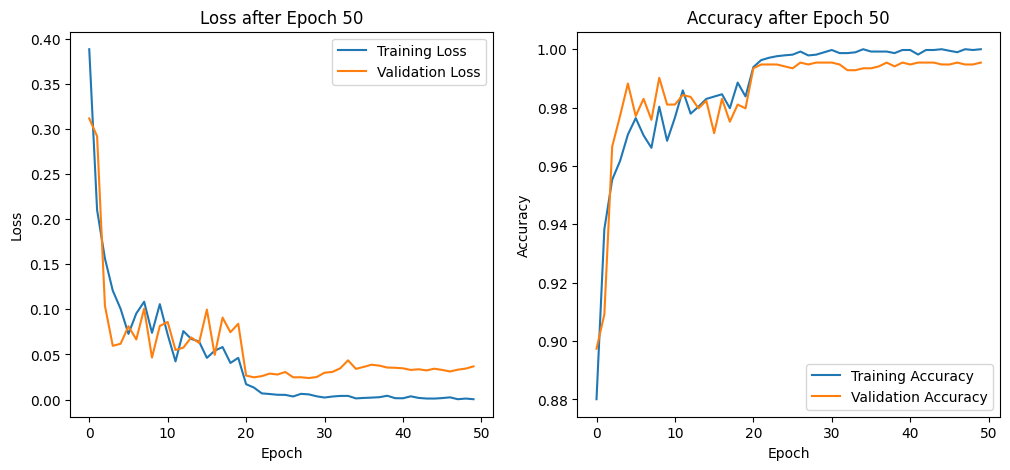

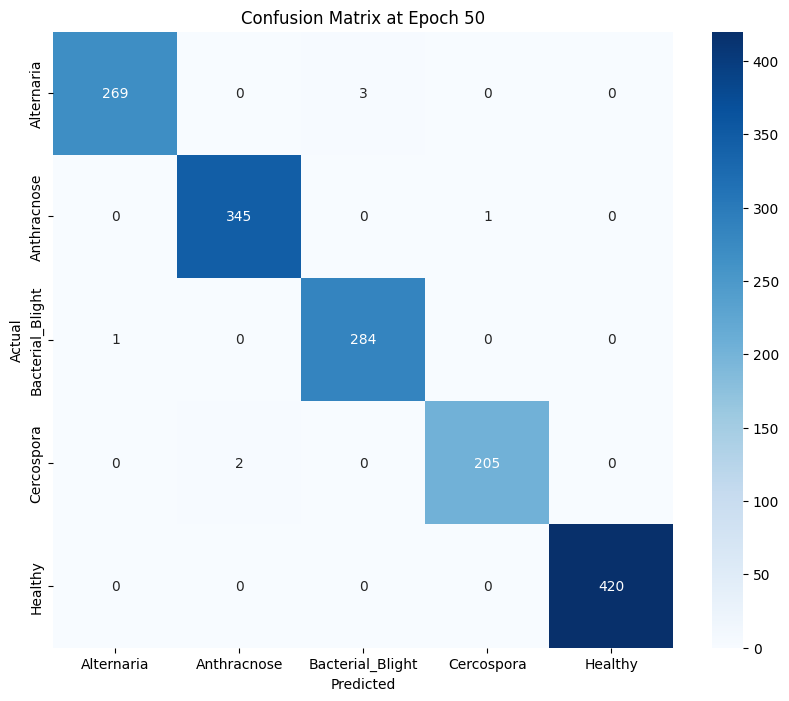

In [22]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Using Cross-Entropy Loss as the criterion for the classification task
criterion = nn.CrossEntropyLoss()

# Setting up the optimizer - Adam optimizer with a learning rate from CFG
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

schedular = ReduceLROnPlateau(optimizer, 'min')  # 'min' for minimizing the validation loss

# Instantiating the PneumoniaTrainer class with the defined criterion and optimizer
trainer = Trainer(criterion, optimizer, schedular)

# Using the fit method of PneumoniaTrainer to start the training and validation process
trainer.fit(model, train_loader, val_loader, epochs=50, device=device)

In [5]:
del model  # Delete the model
torch.cuda.empty_cache()  # Clear GPU cache
print(torch.cuda.memory_allocated()/1024**2)
print(torch.cuda.memory_reserved()/1024**2)

0.0
0.0


In [23]:
conf_matrix = [
    [269, 0, 3, 0, 0],
    [0, 345, 0, 1, 0],
    [1, 0, 284, 0, 0],
    [0, 2, 0, 205, 0],
    [0, 0, 0, 0, 420],
]

In [24]:
weighted_conf_matrix = np.zeros_like(conf_matrix)
for i, row in enumerate(conf_matrix):
    weighted_conf_matrix[i, :] = [count * weights[i] for count in row]

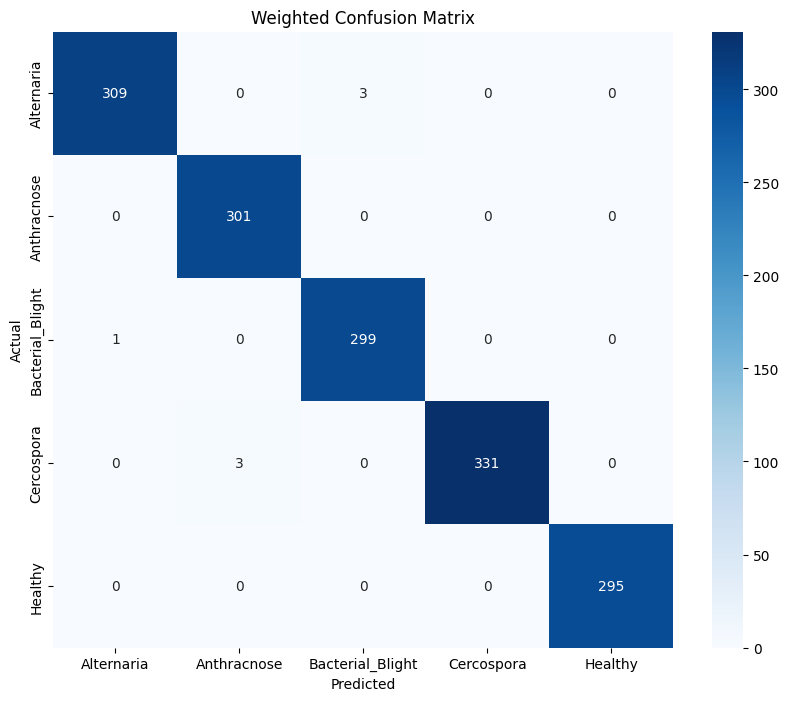

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(weighted_conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Weighted Confusion Matrix")
plt.show()